Load Profile Analysis

Monthly Load Profile Grids

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from scipy.stats import ttest_rel, f_oneway

In [44]:
#plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

In [45]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [46]:
def load_dataset():
    print("Loading cleaned dataset...")
    
    df = pd.read_csv('cleaned_energy_data.csv')
    df['INTERVAL_DATE'] = pd.to_datetime(df['INTERVAL_DATE'])
    
    #time columns 
    time_cols = [col for col in df.columns if '.' in col and '-' in col]
    all_icps = df['ICP_IDENTIFIER'].unique()
    
    print(f"Date range: {df['INTERVAL_DATE'].min().date()} to {df['INTERVAL_DATE'].max().date()}")
    print(f"Number of ICPs: {len(all_icps)}")
 
    #temporal features
    df['Year'] = df['INTERVAL_DATE'].dt.year
    df['Month'] = df['INTERVAL_DATE'].dt.month
    df['DayOfWeek'] = df['INTERVAL_DATE'].dt.day_name()
    df['Season'] = df['Month'].map({12: 'Summer', 1: 'Summer', 2: 'Summer',
                                    3: 'Autumn', 4: 'Autumn', 5: 'Autumn',
                                    6: 'Winter', 7: 'Winter', 8: 'Winter',
                                    9: 'Spring', 10: 'Spring', 11: 'Spring'})
    

    #converting energy (kWh) to average power (kW) for 30-minute intervals
    print("Converting from kWh to kW for power demand analysis...")
    df[time_cols] = df[time_cols] * 2
    df['daily_power_total'] = df[time_cols].sum(axis=1)

    return df, time_cols

In [47]:
def create_hourly_profile_from_row(row, time_cols):
    hourly_profile = []
    for i in range(0, len(time_cols), 2):
        if i + 1 < len(time_cols):
            hourly_profile.append((row[time_cols[i]] + row[time_cols[i+1]]) / 2)
        else:
            hourly_profile.append(row[time_cols[i]])
    return hourly_profile

Monthly load profile grids

In [48]:
def plot_2022_monthly_profiles(df, time_cols):
    
    year_data = df[df['Year'] == 2022]
    
    #time labels for 48 half-hour intervals
    time_labels = [f'{i//2:02d}:{(i%2)*30:02d}' for i in range(48)]
    
    plt.figure(figsize=(20, 12))
    
    for month in range(1, 13):
        month_data = year_data[year_data['Month'] == month]
        
        if len(month_data) > 0:
            #average profile for this month using all 48 intervals
            month_profile = month_data[time_cols].mean()
            
            plt.subplot(3, 4, month)
            plt.plot(range(48), month_profile, color='blue')
            
            #x-axis ticks with time labels
            plt.xticks(range(0, 48, 4), 
                      [time_labels[i] for i in range(0, 48, 4)],  
                      rotation=45)
            
            plt.title(f"{month_names[month-1]}", fontweight='bold')
            plt.xlabel('Time of Day')
            plt.ylabel('Average Consumption (kW)')
            plt.grid(True, alpha=0.3)
    
    plt.suptitle("2022 Average Daily Power Demand Profiles", 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [49]:
def plot_2023_monthly_profiles(df, time_cols):
    
    year_data = df[df['Year'] == 2023]
    
    #time labels for 48 half-hour intervals
    time_labels = [f'{i//2:02d}:{(i%2)*30:02d}' for i in range(48)]
    
    plt.figure(figsize=(20, 12))
    
    for month in range(1, 13):
        month_data = year_data[year_data['Month'] == month]
        
        if len(month_data) > 0:
            #average profile 
            month_profile = month_data[time_cols].mean()
            
            plt.subplot(3, 4, month)
            plt.plot(range(48), month_profile, color='red')
            
            plt.xticks(range(0, 48, 4), 
                      [time_labels[i] for i in range(0, 48, 4)],  
                      rotation=45)
            
            plt.title(f"{month_names[month-1]}", fontweight='bold')
            plt.xlabel('Time of Day')
            plt.ylabel('Average Consumption (kW)')
            plt.grid(True, alpha=0.3)
    
    plt.suptitle("2023 Average Daily Power Demand Profiles", 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [50]:
def plot_2024_monthly_profiles(df, time_cols):
    
    year_data = df[df['Year'] == 2024]
    
    time_labels = [f'{i//2:02d}:{(i%2)*30:02d}' for i in range(48)]
    
    plt.figure(figsize=(18, 12))
    
    for month in range(1, 9):  #jan-aug
        month_data = year_data[year_data['Month'] == month]
        
        if len(month_data) > 0:
            month_profile = month_data[time_cols].mean()
            
            plt.subplot(4, 2, month)
            plt.plot(range(48), month_profile, color='green')
            
            plt.xticks(range(0, 48, 4), 
                      [time_labels[i] for i in range(0, 48, 4)],  
                      rotation=45)
            
            plt.title(f"{month_names[month-1]}", fontweight='bold')
            plt.xlabel('Time of Day')
            plt.ylabel('Average Consumption (kW)')
            plt.grid(True, alpha=0.3)
    
    plt.suptitle("2024 Average Daily Power Demand Profiles (Jan-Sep)", 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [51]:
def plot_seasonal_profiles_by_year(df, time_cols):
    
    #time labels for 48 half-hour intervals
    time_labels = [f'{i//2:02d}:{(i%2)*30:02d}' for i in range(48)]
    
    #seasons and colors
    seasons = ['Summer', 'Autumn', 'Winter', 'Spring']
    years = [2022, 2023, 2024]
    colors = ['blue', 'red', 'green']
    
    plt.figure(figsize=(16, 12))
    
    for i, season in enumerate(seasons):
        plt.subplot(2, 2, i+1)
        
        #each year for this season
        for year, color in zip(years, colors):
            season_year_data = df[(df['Season'] == season) & (df['Year'] == year)]
            
            if len(season_year_data) > 0:
                #average profile for this season and year
                season_profile = season_year_data[time_cols].mean()
                plt.plot(range(48), season_profile, color=color, label=f'{year}', linewidth=2)
        
        plt.xticks(range(0, 48, 4), 
                  [time_labels[i] for i in range(0, 48, 4)],  
                  rotation=45)
        
        plt.title(f"{season}", fontweight='bold', fontsize=14)
        plt.xlabel('Time of Day')
        plt.ylabel('Average Consumption (kW)')
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    plt.suptitle("Seasonal Load Profiles by Year", 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [52]:
def plot_semester_break_vs_term_load_profiles(df, time_cols, academic_file='Key_academic_dates.xlsx'):
    
    time_labels = [f'{i//2:02d}:{(i%2)*30:02d}' for i in range(48)]
    
    #academic dates
    academic = pd.read_excel(academic_file)
    academic['Date'] = pd.to_datetime(academic['Date']).dt.date
    df['INTERVAL_DATE'] = pd.to_datetime(df['INTERVAL_DATE']).dt.date
    
    # unique years in the dataset
    years = sorted(df['INTERVAL_DATE'].apply(lambda x: x.year).unique())
    
    #Christmas/New Year dates (part of semester break)
    christmas_break_dates = set()
    for year in years:
        #Christmas dates
        for day in [25, 26]:
            try:
                christmas_break_dates.add(datetime(year, 12, day).date())
            except:
                pass
        #New Year dates
        for day in range(1, 5):
            try:
                christmas_break_dates.add(datetime(year, 1, day).date())
            except:
                pass
    
    # semester break periods (exclude mid-semester breaks)
    sem_ends = academic[academic['Event'].str.contains('exams end', case=False, na=False)]
    sem_starts = academic[academic['Event'].str.contains('^Semester.*begins$', case=False, na=False)]
    
    semester_break_dates = set()
    for end_date in sem_ends['Date']:
        #next semester start after this end date
        next_starts = [d for d in sem_starts['Date'] if d > end_date]
        if next_starts:
            next_start = min(next_starts)
            #adding all dates between semester end and semester start
            current = end_date + timedelta(days=1)
            while current < next_start:
                semester_break_dates.add(current)
                current += timedelta(days=1)
    
    #initial break period (before first semester starts)
    if len(sem_starts) > 0:
        first_sem_start = min(sem_starts['Date'])
        for year in years:
            start_of_year = datetime(year, 1, 5).date()
            if start_of_year < first_sem_start:
                current = start_of_year
                while current < first_sem_start:
                    semester_break_dates.add(current)
                    current += timedelta(days=1)
    
    #merging Christmas/New Year into semester break dates
    semester_break_dates = semester_break_dates | christmas_break_dates
    
    #classifying each day as either 'Semester Break' or 'Term Time'
    df['period_type'] = 'Term Time'
    df.loc[df['INTERVAL_DATE'].isin(semester_break_dates), 'period_type'] = 'Semester Break'
    
    #average load profiles for each period type
    period_types = ['Term Time', 'Semester Break']
    colors = ['blue', 'red']
    
    plt.figure(figsize=(14, 8))
    
    for period, color in zip(period_types, colors):
        period_data = df[df['period_type'] == period]
        
        if len(period_data) > 0:
            #average load profile for this period
            period_profile = period_data[time_cols].mean()
            plt.plot(range(48), period_profile, color=color, label=period, 
                    linewidth=3, alpha=0.8)
    
    plt.xticks(range(0, 48, 4), 
              [time_labels[i] for i in range(0, 48, 4)],  
              rotation=45)
    
    plt.title("Semester Break vs Term Time Load Profiles", 
              fontsize=16, fontweight='bold')
    plt.xlabel('Time of Day', fontsize=12)
    plt.ylabel('Average Consumption (kW)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    #summary statistics
    print("\nPeriod Summary:")
    for period in period_types:
        period_data = df[df['period_type'] == period]
        if len(period_data) > 0:
            total_days = len(period_data) // len(df['ICP_IDENTIFIER'].unique())  #Approximate days
            avg_consumption = period_data[time_cols].mean().mean()
            peak_hour = period_data[time_cols].mean().idxmax()
            peak_value = period_data[time_cols].mean().max()
            min_hour = period_data[time_cols].mean().idxmin()
            min_value = period_data[time_cols].mean().min()
            
            print(f"\n{period} (~{total_days} days):")
            print(f"  Average consumption: {avg_consumption:.2f} kW")
            print(f"  Peak: {peak_value:.2f} kW at {peak_hour}")
            print(f"  Minimum: {min_value:.2f} kW at {min_hour}")
            print(f"  Peak-to-minimum ratio: {peak_value/min_value:.2f}")
    
    #period distribution
    period_counts = df['period_type'].value_counts()
    print(f"\nData Distribution:")
    for period, count in period_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {period}: {count:,} records ({percentage:.1f}%)")

In [53]:
def identify_term_time(df, academic_file='Key_academic_dates.xlsx'):
   from datetime import datetime, timedelta
   
   #academic dates
   academic = pd.read_excel(academic_file)
   academic['Date'] = pd.to_datetime(academic['Date']).dt.date
   df['INTERVAL_DATE'] = pd.to_datetime(df['INTERVAL_DATE']).dt.date
   
   # unique years in the dataset
   years = sorted(df['INTERVAL_DATE'].apply(lambda x: x.year).unique())
   
   #Christmas/New Year dates (part of semester break)
   christmas_break_dates = set()
   for year in years:
       #Christmas dates
       for day in [25, 26]:
           try:
               christmas_break_dates.add(datetime(year, 12, day).date())
           except:
               pass
       #New Year dates
       for day in range(1, 5):
           try:
               christmas_break_dates.add(datetime(year, 1, day).date())
           except:
               pass
   
   # semester break periods (exclude mid-semester breaks)
   sem_ends = academic[academic['Event'].str.contains('exams end', case=False, na=False)]
   sem_starts = academic[academic['Event'].str.contains('^Semester.*begins$', case=False, na=False)]
   
   semester_break_dates = set()
   for end_date in sem_ends['Date']:
       #next semester start after this end date
       next_starts = [d for d in sem_starts['Date'] if d > end_date]
       if next_starts:
           next_start = min(next_starts)
           #adding all dates between semester end and semester start
           current = end_date + timedelta(days=1)
           while current < next_start:
               semester_break_dates.add(current)
               current += timedelta(days=1)
   
   #initial break period (before first semester starts)
   if len(sem_starts) > 0:
       first_sem_start = min(sem_starts['Date'])
       for year in years:
           start_of_year = datetime(year, 1, 5).date()
           if start_of_year < first_sem_start:
               current = start_of_year
               while current < first_sem_start:
                   semester_break_dates.add(current)
                   current += timedelta(days=1)
   
   #merging Christmas/New Year into semester break dates
   semester_break_dates = semester_break_dates | christmas_break_dates
   
   #classifying each day as either 'Semester Break' or 'Term Time'
   df['period_type'] = 'Term Time'
   df.loc[df['INTERVAL_DATE'].isin(semester_break_dates), 'period_type'] = 'Semester Break'
   
   #filter to term time only
   term_time_df = df[df['period_type'] == 'Term Time'].copy()
   
   return term_time_df

In [54]:
def plot_weekend_vs_weekday_profile(df, time_cols, academic_file='Key_academic_dates.xlsx'):
    
    time_labels = [f'{i//2:02d}:{(i%2)*30:02d}' for i in range(48)]
    
    #filtering to term time only 
    term_time_df = identify_term_time(df, academic_file)
    
    #weekday and weekend categories
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    weekends = ['Saturday', 'Sunday']
    
    #weekdays vs weekends within term time
    term_time_df['day_type'] = 'Weekday'
    term_time_df.loc[term_time_df['DayOfWeek'].isin(weekends), 'day_type'] = 'Weekend'
    
    #average load profiles for each day type
    day_types = ['Weekday', 'Weekend']
    colors = ['blue', 'red']
    
    plt.figure(figsize=(16, 8))
    
    #comparison plot
    plt.subplot(1, 3, 1)
    
    for day_type, color in zip(day_types, colors):
        day_data = term_time_df[term_time_df['day_type'] == day_type]
        
        if len(day_data) > 0:
            #average load profile for this day type
            day_profile = day_data[time_cols].mean()
            plt.plot(range(48), day_profile, color=color, label=day_type, 
                    linewidth=3, alpha=0.8)
    
    plt.xticks(range(0, 48, 4), 
              [time_labels[i] for i in range(0, 48, 4)],  
              rotation=45)
    
    plt.title("Weekend vs Weekday Load Profiles\n(Term Time Only)", 
              fontsize=14, fontweight='bold')
    plt.xlabel('Time of Day')
    plt.ylabel('Average Power Demand (kW)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    #difference analysis
    plt.subplot(1, 3, 2)
    
    weekday_data = term_time_df[term_time_df['day_type'] == 'Weekday']
    weekend_data = term_time_df[term_time_df['day_type'] == 'Weekend']
    
    weekday_profile = weekday_data[time_cols].mean()
    weekend_profile = weekend_data[time_cols].mean()
    
    #difference (Weekend - Weekday)
    difference_profile = weekend_profile - weekday_profile
    
    #bar plot 
    bars = plt.bar(range(48), difference_profile, 
                   color=['red' if x > 0 else 'blue' for x in difference_profile],
                   alpha=0.7, width=0.8)
    
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.xticks(range(0, 48, 4), [time_labels[i] for i in range(0, 48, 4)], rotation=45)
    plt.title("Weekend - Weekday Difference\n(Positive = Higher Weekend Usage)", 
              fontweight='bold', fontsize=14)
    plt.xlabel('Time of Day')
    plt.ylabel('Power Difference (kW)')
    plt.grid(True, alpha=0.3, axis='y')
    
    #peak hour analysis
    plt.subplot(1, 3, 3)
    
    #focus on evening hours (5 PM to 11 PM)
    evening_start, evening_end = 34, 46  # 17:00 to 23:00
    
    weekday_evening = weekday_profile[evening_start:evening_end]
    weekend_evening = weekend_profile[evening_start:evening_end]
    evening_times = range(evening_start, evening_end)
    
    plt.plot(evening_times, weekday_evening, color='blue', linewidth=3, 
             label='Weekday Evening', marker='o', markersize=4)
    plt.plot(evening_times, weekend_evening, color='red', linewidth=3, 
             label='Weekend Evening', marker='s', markersize=4)
    
    plt.xticks(range(evening_start, evening_end, 2), 
              [time_labels[i] for i in range(evening_start, evening_end, 2)], rotation=45)
    plt.title("Evening Peak Hours Comparison\n(5 PM - 11 PM, Term Time)", 
              fontweight='bold', fontsize=14)
    plt.xlabel('Time of Day')
    plt.ylabel('Average Power Demand (kW)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    #summary statistics
    print("\nDay Type Summary (Term Time Only):")
    for day_type in day_types:
        day_data = term_time_df[term_time_df['day_type'] == day_type]
        if len(day_data) > 0:
            total_days = len(day_data) // len(df['ICP_IDENTIFIER'].unique())
            avg_consumption = day_data[time_cols].mean().mean()
            peak_hour = day_data[time_cols].mean().idxmax()
            peak_value = day_data[time_cols].mean().max()
            min_hour = day_data[time_cols].mean().idxmin()
            min_value = day_data[time_cols].mean().min()
            
            print(f"\n{day_type} (~{total_days} days):")
            print(f"  Average consumption: {avg_consumption:.2f} kW")
            print(f"  Peak: {peak_value:.2f} kW at {peak_hour}")
            print(f"  Minimum: {min_value:.2f} kW at {min_hour}")
            print(f"  Peak-to-minimum ratio: {peak_value/min_value:.2f}")
    
    #data distribution
    day_type_counts = term_time_df['day_type'].value_counts()
    print(f"\nTerm Time Data Distribution:")
    for day_type, count in day_type_counts.items():
        percentage = (count / len(term_time_df)) * 100
        print(f"  {day_type}: {count:,} records ({percentage:.1f}%)")

In [55]:
def identify_exam_periods(df, academic_file='Key_academic_dates.xlsx'):
    from datetime import datetime, timedelta
    
    #academic dates
    academic = pd.read_excel(academic_file)
    academic['Date'] = pd.to_datetime(academic['Date']).dt.date
    df['INTERVAL_DATE'] = pd.to_datetime(df['INTERVAL_DATE']).dt.date
    
    #exam periods
    exam_starts = academic[academic['Event'].str.contains('exams begin', case=False, na=False)]
    exam_ends = academic[academic['Event'].str.contains('exams end', case=False, na=False)]
    
    exam_dates = set()
    for start_date in exam_starts['Date']:
        #corresponding exam end date
        matching_ends = [d for d in exam_ends['Date'] if d > start_date]
        if matching_ends:
            end_date = min(matching_ends)
            #adding all dates between exam start and end
            current = start_date
            while current <= end_date:
                exam_dates.add(current)
                current += timedelta(days=1)
    
    #classifying periods
    df['exam_period'] = 'Regular Term'
    df.loc[df['INTERVAL_DATE'].isin(exam_dates), 'exam_period'] = 'Exam Period'
    
    #summary
    total_records = len(df)
    exam_records = len(df[df['exam_period'] == 'Exam Period'])
    
    print(f"Exam Period Identification Results:")
    print(f"  Total records: {total_records:,}")
    print(f"  Exam Period: {exam_records:,} records ({exam_records/total_records*100:.1f}%)")
    print(f"  Regular Term: {total_records - exam_records:,} records ({(total_records - exam_records)/total_records*100:.1f}%)")
    
    return df

In [56]:
def plot_exam_vs_regular_term_profile(df, time_cols, academic_file='Key_academic_dates.xlsx'):
   time_labels = [f'{i//2:02d}:{(i%2)*30:02d}' for i in range(48)]
   df_with_exams = identify_exam_periods(df, academic_file)
   
   #split into exam and regular term data
   exam_df = df_with_exams[df_with_exams['exam_period'] == 'Exam Period']
   regular_df = df_with_exams[df_with_exams['exam_period'] == 'Regular Term']
   
   #average load profiles for each period type
   plt.figure(figsize=(14, 6))
   
   #main comparison plot
   plt.subplot(1, 2, 1)
   
   if len(regular_df) > 0:
       regular_profile = regular_df[time_cols].mean()
       plt.plot(range(48), regular_profile, color='blue', label='Regular Term', 
               linewidth=3, alpha=0.8)
   
   if len(exam_df) > 0:
       exam_profile = exam_df[time_cols].mean()
       plt.plot(range(48), exam_profile, color='red', label='Exam Period', 
               linewidth=3, alpha=0.8)
   
   plt.xticks(range(0, 48, 4), 
             [time_labels[i] for i in range(0, 48, 4)],  
             rotation=45)
   
   plt.title("Exam vs Regular Term Load Profiles", 
             fontsize=14, fontweight='bold')
   plt.xlabel('Time of Day')
   plt.ylabel('Average Power Demand (kW)')
   plt.grid(True, alpha=0.3)
   plt.legend()
   
   #late night study analysis (9 PM to 4 AM)
   plt.subplot(1, 2, 2)
   
   if len(regular_df) > 0 and len(exam_df) > 0:
       #late night hours (9 PM to 4 AM)
       night_start, night_end = 42, 8  #21:00 to 04:00
       
       #wrap-around midnight
       night_regular = list(regular_profile[night_start:48]) + list(regular_profile[0:night_end])
       night_exam = list(exam_profile[night_start:48]) + list(exam_profile[0:night_end])
       night_times = list(range(night_start, 48)) + list(range(0, night_end))
       
       plt.plot(range(len(night_times)), night_regular, color='blue', linewidth=3, 
                label='Regular Term', marker='o', markersize=4)
       plt.plot(range(len(night_times)), night_exam, color='red', linewidth=3, 
                label='Exam Period', marker='s', markersize=4)
       
       #x-axis labels for night hours
       night_labels = [time_labels[i] for i in night_times]
       plt.xticks(range(0, len(night_times), 2), 
                 [night_labels[i] for i in range(0, len(night_times), 2)], rotation=45)
   
   plt.title("Late Night Study Pattern\n(9 PM - 4 AM)", 
             fontweight='bold', fontsize=14)
   plt.xlabel('Time of Day')
   plt.ylabel('Average Power Demand (kW)')
   plt.grid(True, alpha=0.3)
   plt.legend()
   
   plt.tight_layout()
   plt.show()
   
   #summary statistics
   print("\nPeriod Summary:")
   if len(regular_df) > 0:
       total_days = len(regular_df) // len(df['ICP_IDENTIFIER'].unique())
       avg_consumption = regular_df[time_cols].mean().mean()
       peak_hour = regular_df[time_cols].mean().idxmax()
       peak_value = regular_df[time_cols].mean().max()
       min_hour = regular_df[time_cols].mean().idxmin()
       min_value = regular_df[time_cols].mean().min()
       
       print(f"\nRegular Term (~{total_days} days):")
       print(f"  Average consumption: {avg_consumption:.2f} kW")
       print(f"  Peak: {peak_value:.2f} kW at {peak_hour}")
       print(f"  Minimum: {min_value:.2f} kW at {min_hour}")
       print(f"  Peak-to-minimum ratio: {peak_value/min_value:.2f}")
   
   if len(exam_df) > 0:
       total_days = len(exam_df) // len(df['ICP_IDENTIFIER'].unique())
       avg_consumption = exam_df[time_cols].mean().mean()
       peak_hour = exam_df[time_cols].mean().idxmax()
       peak_value = exam_df[time_cols].mean().max()
       min_hour = exam_df[time_cols].mean().idxmin()
       min_value = exam_df[time_cols].mean().min()
       
       print(f"\nExam Period (~{total_days} days):")
       print(f"  Average consumption: {avg_consumption:.2f} kW")
       print(f"  Peak: {peak_value:.2f} kW at {peak_hour}")
       print(f"  Minimum: {min_value:.2f} kW at {min_hour}")
       print(f"  Peak-to-minimum ratio: {peak_value/min_value:.2f}")
   
   #late night comparison
   if len(regular_df) > 0 and len(exam_df) > 0:
       print(f"\nLate Night Study Analysis (9 PM - 4 AM):")
       regular_night_avg = sum(night_regular) / len(night_regular)
       exam_night_avg = sum(night_exam) / len(night_exam)
       print(f"  Regular Term: {regular_night_avg:.2f} kW")
       print(f"  Exam Period: {exam_night_avg:.2f} kW")
       print(f"  Exam/Regular ratio: {exam_night_avg/regular_night_avg:.2f}x")

In [57]:
def analyze_peak_load_timing(df, time_cols, academic_file='Key_academic_dates.xlsx'):
   time_labels = [f'{i//2:02d}:{(i%2)*30:02d}' for i in range(48)]
   
   #exam classification 
   df_with_exams = identify_exam_periods(df, academic_file)
   
   #different periods for comparison
   weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
   weekends = ['Saturday', 'Sunday']
   
   #profiles for different periods
   all_profile = df_with_exams[time_cols].mean()
   weekday_profile = df_with_exams[df_with_exams['DayOfWeek'].isin(weekdays)][time_cols].mean()
   weekend_profile = df_with_exams[df_with_exams['DayOfWeek'].isin(weekends)][time_cols].mean()
   
   #exam vs regular profiles
   exam_df = df_with_exams[df_with_exams['exam_period'] == 'Exam Period']
   regular_df = df_with_exams[df_with_exams['exam_period'] == 'Regular Term']
   
   exam_profile = exam_df[time_cols].mean() if len(exam_df) > 0 else None
   regular_profile = regular_df[time_cols].mean() if len(regular_df) > 0 else None
   
   #plots
   plt.figure(figsize=(16, 10))
   
   #basic peak timing comparison
   plt.subplot(2, 2, 1)
   
   plt.plot(range(48), all_profile, color='black', linewidth=3, label='Overall Average', alpha=0.8)
   plt.plot(range(48), weekday_profile, color='blue', linewidth=2, label='Weekdays', alpha=0.7)
   plt.plot(range(48), weekend_profile, color='red', linewidth=2, label='Weekends', alpha=0.7)
   
   overall_peak_idx = all_profile.idxmax()
   weekday_peak_idx = weekday_profile.idxmax()
   weekend_peak_idx = weekend_profile.idxmax()
   
   #converting column names to time indices 
   overall_peak_time = int(overall_peak_idx.split('.')[0]) * 2 + (1 if '30' in overall_peak_idx else 0)
   weekday_peak_time = int(weekday_peak_idx.split('.')[0]) * 2 + (1 if '30' in weekday_peak_idx else 0)
   weekend_peak_time = int(weekend_peak_idx.split('.')[0]) * 2 + (1 if '30' in weekend_peak_idx else 0)
   
   plt.axvline(x=overall_peak_time, color='black', linestyle='--', alpha=0.7)
   plt.axvline(x=weekday_peak_time, color='blue', linestyle='--', alpha=0.7)
   plt.axvline(x=weekend_peak_time, color='red', linestyle='--', alpha=0.7)
   
   plt.xticks(range(0, 48, 4), [time_labels[i] for i in range(0, 48, 4)], rotation=45)
   plt.title("Peak Load Timing Analysis", fontweight='bold', fontsize=14)
   plt.xlabel('Time of Day')
   plt.ylabel('Average Power Demand (kW)')
   plt.grid(True, alpha=0.3)
   plt.legend()
   
   #exam vs regular peak timing
   plt.subplot(2, 2, 2)
   
   if regular_profile is not None:
       plt.plot(range(48), regular_profile, color='blue', linewidth=3, label='Regular Term', alpha=0.8)
       regular_peak_idx = regular_profile.idxmax()
       regular_peak_time = int(regular_peak_idx.split('.')[0]) * 2 + (1 if '30' in regular_peak_idx else 0)
       plt.axvline(x=regular_peak_time, color='blue', linestyle='--', alpha=0.7)
   
   if exam_profile is not None:
       plt.plot(range(48), exam_profile, color='red', linewidth=3, label='Exam Period', alpha=0.8)
       exam_peak_idx = exam_profile.idxmax()
       exam_peak_time = int(exam_peak_idx.split('.')[0]) * 2 + (1 if '30' in exam_peak_idx else 0)
       plt.axvline(x=exam_peak_time, color='red', linestyle='--', alpha=0.7)
   
   plt.xticks(range(0, 48, 4), [time_labels[i] for i in range(0, 48, 4)], rotation=45)
   plt.title("Peak Timing: Exam vs Regular Periods", fontweight='bold', fontsize=14)
   plt.xlabel('Time of Day')
   plt.ylabel('Average Power Demand (kW)')
   plt.grid(True, alpha=0.3)
   plt.legend()
   
   #peak duration analysis
   plt.subplot(2, 2, 3)
   
   #peak as 90% of maximum load
   peak_threshold = all_profile.max() * 0.9
   
   #bar plot
   colors = ['red' if val >= peak_threshold else 'lightblue' for val in all_profile]
   
   plt.bar(range(48), all_profile, color=colors, alpha=0.7, width=0.8)
   plt.axhline(y=peak_threshold, color='red', linestyle='--', linewidth=2, 
               label=f'Peak Threshold (90% of max: {peak_threshold:.2f} kW)')
   
   plt.xticks(range(0, 48, 4), [time_labels[i] for i in range(0, 48, 4)], rotation=45)
   plt.title("Peak Load Duration Analysis", fontweight='bold', fontsize=14)
   plt.xlabel('Time of Day')
   plt.ylabel('Average Power Demand (kW)')
   plt.grid(True, alpha=0.3, axis='y')
   plt.legend()
   
   #monthly peak timing variation
   plt.subplot(2, 2, 4)
   
   #month column
   df_with_exams['Month'] = pd.to_datetime(df_with_exams['INTERVAL_DATE']).dt.month
   
   monthly_peaks = {}
   monthly_peak_values = {}
   
   for month in sorted(df_with_exams['Month'].unique()):
       month_data = df_with_exams[df_with_exams['Month'] == month]
       if len(month_data) > 0:
           month_profile = month_data[time_cols].mean()
           peak_idx = month_profile.idxmax()
           peak_time = int(peak_idx.split('.')[0]) * 2 + (1 if '30' in peak_idx else 0)
           monthly_peaks[month] = peak_time
           monthly_peak_values[month] = month_profile.max()
   
   months = list(monthly_peaks.keys())
   peak_times = list(monthly_peaks.values())
   
   plt.scatter(months, peak_times, s=100, color='red', alpha=0.7)
   plt.plot(months, peak_times, color='red', alpha=0.5)
   
   #converting peak times back to hour labels 
   y_ticks = range(32, 48, 2)  #4 PM to midnight
   y_labels = [f"{i//2:02d}:{(i%2)*30:02d}" for i in y_ticks]
   plt.yticks(y_ticks, y_labels)
   
   month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
   available_months = [month_names[m-1] for m in months]
   plt.xticks(months, available_months, rotation=45)
   
   plt.title("Peak Timing by Month", fontweight='bold', fontsize=14)
   plt.xlabel('Month')
   plt.ylabel('Peak Time')
   plt.grid(True, alpha=0.3)
   
   plt.tight_layout()
   plt.show()
   
   #summary statistics
   print("Peak load timing analysis summary")

   print(f"\nOverall Peak Analysis:")
   print(f"  Peak time: {time_labels[overall_peak_time]}")
   print(f"  Peak value: {all_profile.max():.2f} kW")
   
   #peak duration intervals
   peak_hours = all_profile[all_profile >= peak_threshold]
   print(f"  Peak duration (≥90% max): {len(peak_hours)} intervals ({len(peak_hours)*0.5:.1f} hours)")
   
   print(f"\nWeekday vs Weekend Peak Timing:")
   print(f"  Weekday peak: {time_labels[weekday_peak_time]} ({weekday_profile.max():.2f} kW)")
   print(f"  Weekend peak: {time_labels[weekend_peak_time]} ({weekend_profile.max():.2f} kW)")
   time_diff = abs(weekday_peak_time - weekend_peak_time) * 0.5
   print(f"  Time difference: {time_diff:.1f} hours")
   
   if regular_profile is not None and exam_profile is not None:
       print(f"\nExam vs Regular Peak Timing:")
       print(f"  Regular term peak: {time_labels[regular_peak_time]} ({regular_profile.max():.2f} kW)")
       print(f"  Exam period peak: {time_labels[exam_peak_time]} ({exam_profile.max():.2f} kW)")
       exam_increase = ((exam_profile.max() - regular_profile.max()) / regular_profile.max() * 100)
       print(f"  Exam peak increase: {exam_increase:+.1f}%")
   
   print(f"\nSeasonal Peak Variation:")
   if len(peak_times) > 1:
       peak_time_range = max(peak_times) - min(peak_times)
       print(f"  Earliest monthly peak: {time_labels[min(peak_times)]}")
       print(f"  Latest monthly peak: {time_labels[max(peak_times)]}")
       print(f"  Seasonal variation: {peak_time_range*0.5:.1f} hours")
   
   

In [58]:
def analyze_off_peak_timing(df, time_cols):
    
    
    time_labels = [f'{i//2:02d}:{(i%2)*30:02d}' for i in range(48)]
    
    #periods for comparison
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    weekends = ['Saturday', 'Sunday']
    
    #profiles for different periods
    all_profile = df[time_cols].mean()
    weekday_profile = df[df['DayOfWeek'].isin(weekdays)][time_cols].mean()
    weekend_profile = df[df['DayOfWeek'].isin(weekends)][time_cols].mean()
    
    #plots
    plt.figure(figsize=(16, 10))
    
    #basic off-peak timing comparison
    plt.subplot(2, 2, 1)
    
    plt.plot(range(48), all_profile, color='black', linewidth=3, label='Overall Average', alpha=0.8)
    plt.plot(range(48), weekday_profile, color='blue', linewidth=2, label='Weekdays', alpha=0.7)
    plt.plot(range(48), weekend_profile, color='red', linewidth=2, label='Weekends', alpha=0.7)
    
    #minimum load times
    overall_min_idx = all_profile.idxmin()
    weekday_min_idx = weekday_profile.idxmin()
    weekend_min_idx = weekend_profile.idxmin()
    
    #converting column names to time indices
    overall_min_time = int(overall_min_idx.split('.')[0]) * 2 + (1 if '30' in overall_min_idx else 0)
    weekday_min_time = int(weekday_min_idx.split('.')[0]) * 2 + (1 if '30' in weekday_min_idx else 0)
    weekend_min_time = int(weekend_min_idx.split('.')[0]) * 2 + (1 if '30' in weekend_min_idx else 0)
    
    plt.axvline(x=overall_min_time, color='black', linestyle=':', alpha=0.7)
    plt.axvline(x=weekday_min_time, color='blue', linestyle='--', alpha=0.7)
    plt.axvline(x=weekend_min_time, color='red', linestyle='--', alpha=0.7)
    
    plt.xticks(range(0, 48, 4), [time_labels[i] for i in range(0, 48, 4)], rotation=45)
    plt.title("Off-Peak Load Timing Analysis", fontweight='bold', fontsize=14)
    plt.xlabel('Time of Day')
    plt.ylabel('Average Power Demand (kW)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    #off-peak duration analysis
    plt.subplot(2, 2, 2)
    
    #off-peak as 110% of minimum load
    off_peak_threshold = all_profile.min() * 1.1
    
    #bar plot
    colors = ['green' if val <= off_peak_threshold else 'lightcoral' for val in all_profile]
    
    plt.bar(range(48), all_profile, color=colors, alpha=0.7, width=0.8)
    plt.axhline(y=off_peak_threshold, color='green', linestyle='--', linewidth=2, 
                label=f'Off-Peak Threshold (110% of min: {off_peak_threshold:.2f} kW)')
    
    plt.xticks(range(0, 48, 4), [time_labels[i] for i in range(0, 48, 4)], rotation=45)
    plt.title("Off-Peak Load Duration Analysis", fontweight='bold', fontsize=14)
    plt.xlabel('Time of Day')
    plt.ylabel('Average Power Demand (kW)')
    plt.grid(True, alpha=0.3, axis='y')
    plt.legend()
    
    #load valley analysis
    plt.subplot(2, 2, 3)
    
    #oad factor
    max_load = all_profile.max()
    load_factor = all_profile / max_load * 100
    
    plt.fill_between(range(48), load_factor, alpha=0.6, color='lightblue', label='Load Factor (%)')
    plt.plot(range(48), load_factor, color='darkblue', linewidth=2)
    
    #minimum load factor
    min_load_factor = load_factor.min()
    plt.axhline(y=min_load_factor, color='red', linestyle='--', linewidth=2, 
                label=f'Minimum Load Factor: {min_load_factor:.1f}%')
    
    plt.xticks(range(0, 48, 4), [time_labels[i] for i in range(0, 48, 4)], rotation=45)
    plt.title("Load Factor Analysis (% of Peak)", fontweight='bold', fontsize=14)
    plt.xlabel('Time of Day')
    plt.ylabel('Load Factor (%)')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    #monthly off-peak timing variation
    plt.subplot(2, 2, 4)
    
    #month column
    df['Month'] = pd.to_datetime(df['INTERVAL_DATE']).dt.month
    
    monthly_mins = {}
    monthly_min_values = {}
    
    for month in sorted(df['Month'].unique()):
        month_data = df[df['Month'] == month]
        if len(month_data) > 0:
            month_profile = month_data[time_cols].mean()
            min_idx = month_profile.idxmin()
            min_time = int(min_idx.split('.')[0]) * 2 + (1 if '30' in min_idx else 0)
            monthly_mins[month] = min_time
            monthly_min_values[month] = month_profile.min()
    
    months = list(monthly_mins.keys())
    min_times = list(monthly_mins.values())
    
    plt.scatter(months, min_times, s=100, color='green', alpha=0.7)
    plt.plot(months, min_times, color='green', alpha=0.5)
    
    #converting min times back to hour labels 
    y_ticks = range(0, 16, 2)  #midnight to 8 AM
    y_labels = [f"{i//2:02d}:{(i%2)*30:02d}" for i in y_ticks]
    plt.yticks(y_ticks, y_labels)
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    available_months = [month_names[m-1] for m in months]
    plt.xticks(months, available_months, rotation=45)
    
    plt.title("Off-Peak Timing by Month", fontweight='bold', fontsize=14)
    plt.xlabel('Month')
    plt.ylabel('Off-Peak Time')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    #summary statistics
    print("Off-peak load timing analysis summary")
    
    print(f"\nOverall Off-Peak Analysis:")
    print(f"  Off-peak time: {time_labels[overall_min_time]}")
    print(f"  Minimum load: {all_profile.min():.2f} kW")
    print(f"  Maximum load: {all_profile.max():.2f} kW")
    print(f"  Load variation: {((all_profile.max() - all_profile.min()) / all_profile.min() * 100):.1f}%")
    
    #off-peak duration intervals
    off_peak_hours = all_profile[all_profile <= off_peak_threshold]
    print(f"  Off-peak duration (≤110% min): {len(off_peak_hours)} intervals ({len(off_peak_hours)*0.5:.1f} hours)")
    
    print(f"\nWeekday vs Weekend Off-Peak Timing:")
    print(f"  Weekday off-peak: {time_labels[weekday_min_time]} ({weekday_profile.min():.2f} kW)")
    print(f"  Weekend off-peak: {time_labels[weekend_min_time]} ({weekend_profile.min():.2f} kW)")
    time_diff = abs(weekday_min_time - weekend_min_time) * 0.5
    print(f"  Time difference: {time_diff:.1f} hours")
    
    print(f"\nLoad Shifting Potential:")
    spare_capacity_at_min = all_profile.max() - all_profile.min()
    print(f"  Maximum spare capacity: {spare_capacity_at_min:.2f} kW")
    print(f"  Load factor range: {min_load_factor:.1f}% - 100%")
    print(f"  Available capacity: {100 - min_load_factor:.1f}% of peak demand")
    
    print(f"\nSeasonal Off-Peak Variation:")
    if len(min_times) > 1:
        min_time_range = max(min_times) - min(min_times)
        print(f"  Earliest monthly off-peak: {time_labels[min(min_times)]}")
        print(f"  Latest monthly off-peak: {time_labels[max(min_times)]}")
        print(f"  Seasonal variation: {min_time_range*0.5:.1f} hours")
    
    return {
        'overall_min_time': time_labels[overall_min_time],
        'min_load': all_profile.min(),
        'max_load': all_profile.max(),
        'spare_capacity': spare_capacity_at_min,
        'off_peak_duration': len(off_peak_hours)*0.5,
        'load_factor_range': (min_load_factor, 100)
    }

In [59]:
def analyze_complete_summer_vs_winter(df, time_cols):

    time_labels = [f'{i//2:02d}:{(i%2)*30:02d}' for i in range(48)]
    
    #month column
    df['Month'] = pd.to_datetime(df['INTERVAL_DATE']).dt.month
    
    july_data = df[df['Month'] == 7]  #peak winter
    feb_data = df[df['Month'] == 2]   #peak summer
    
    if len(july_data) > 0 and len(feb_data) > 0:
        july_profile = july_data[time_cols].mean()
        feb_profile = feb_data[time_cols].mean()
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        #peak load comparison
        ax1 = axes[0]
        ax1.plot(range(48), july_profile, color='blue', linewidth=3, label='July (Winter)', markersize=3)
        ax1.plot(range(48), feb_profile, color='red', linewidth=3, label='February (Summer)', markersize=3)
        
        #mark peaks
        july_peak_idx = july_profile.idxmax()
        feb_peak_idx = feb_profile.idxmax()
        july_peak_time = int(july_peak_idx.split('.')[0]) * 2 + (1 if '30' in july_peak_idx else 0)
        feb_peak_time = int(feb_peak_idx.split('.')[0]) * 2 + (1 if '30' in feb_peak_idx else 0)
        
        ax1.axvline(x=july_peak_time, color='blue', linestyle='--', alpha=0.7)
        ax1.axvline(x=feb_peak_time, color='red', linestyle='--', alpha=0.7)
        
        ax1.set_xticks(range(0, 48, 4))
        ax1.set_xticklabels([time_labels[i] for i in range(0, 48, 4)], rotation=45)
        ax1.set_title("Peak Load Comparison", fontweight='bold', fontsize=14)
        ax1.set_xlabel('Time of Day')
        ax1.set_ylabel('Average Power Demand (kW)')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        #off-peak load comparison
        ax2 = axes[1]
        ax2.plot(range(48), july_profile, color='blue', linewidth=3, label='July (Winter)', markersize=3)
        ax2.plot(range(48), feb_profile, color='red', linewidth=3, label='February (Summer)', markersize=3)
        
        #mark off-peaks
        july_min_idx = july_profile.idxmin()
        feb_min_idx = feb_profile.idxmin()
        july_min_time = int(july_min_idx.split('.')[0]) * 2 + (1 if '30' in july_min_idx else 0)
        feb_min_time = int(feb_min_idx.split('.')[0]) * 2 + (1 if '30' in feb_min_idx else 0)
        
        ax2.axvline(x=july_min_time, color='blue', linestyle='--', alpha=0.7)
        ax2.axvline(x=feb_min_time, color='red', linestyle='--', alpha=0.7)
        
        #focus on off-peak hours (midnight to 8 AM)
        ax2.set_xlim(0, 16)
        ax2.set_xticks(range(0, 17, 2))
        ax2.set_xticklabels([time_labels[i] for i in range(0, 17, 2)], rotation=45)
        ax2.set_title("Off-Peak Load Comparison (Focus: 00:00-08:00)", fontweight='bold', fontsize=14)
        ax2.set_xlabel('Time of Day')
        ax2.set_ylabel('Average Power Demand (kW)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        #peak vs off-peak summary
        ax3 = axes[2]
        
        categories = ['Peak Load\n(kW)', 'Peak Time', 'Off-Peak Load\n(kW)', 'Off-Peak Time', 'Daily Range\n(kW)']
        july_values = [july_profile.max(), f"{time_labels[july_peak_time]}", 
                      july_profile.min(), f"{time_labels[july_min_time]}", 
                      july_profile.max() - july_profile.min()]
        feb_values = [feb_profile.max(), f"{time_labels[feb_peak_time]}", 
                     feb_profile.min(), f"{time_labels[feb_min_time]}", 
                     feb_profile.max() - feb_profile.min()]
        
        x = range(len(categories))
        width = 0.35
        
        #plot numeric values
        numeric_cats = ['Peak Load\n(kW)', 'Off-Peak Load\n(kW)', 'Daily Range\n(kW)']
        numeric_july = [july_values[i] for i in [0, 2, 4]]
        numeric_feb = [feb_values[i] for i in [0, 2, 4]]
        
        ax3.bar([i - width/2 for i in range(3)], numeric_july, width, 
                label='July (Winter)', color='blue', alpha=0.7)
        ax3.bar([i + width/2 for i in range(3)], numeric_feb, width, 
                label='February (Summer)', color='red', alpha=0.7)
        
        ax3.set_xticks(range(3))
        ax3.set_xticklabels(numeric_cats)
        ax3.set_title("Peak vs Off-Peak Summary", fontweight='bold', fontsize=14)
        ax3.set_ylabel('Power (kW)')
        ax3.legend()
        ax3.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        #summary statistics
        print(f"\nJULY (PEAK WINTER) ANALYSIS:")
        print(f"Peak time: {time_labels[july_peak_time]} | Peak value: {july_profile.max():.2f} kW")
        print(f"Off-peak time: {time_labels[july_min_time]} | Off-peak value: {july_profile.min():.2f} kW")
        print(f"Daily range: {july_profile.max() - july_profile.min():.2f} kW")
        print(f"Average consumption: {july_profile.mean():.2f} kW")
        print(f"Data points: {len(july_data):,} records")
        
        print(f"\nFEBRUARY (PEAK SUMMER) ANALYSIS:")
        print(f"Peak time: {time_labels[feb_peak_time]} | Peak value: {feb_profile.max():.2f} kW")
        print(f"Off-peak time: {time_labels[feb_min_time]} | Off-peak value: {feb_profile.min():.2f} kW")
        print(f"Daily range: {feb_profile.max() - feb_profile.min():.2f} kW")
        print(f"Average consumption: {feb_profile.mean():.2f} kW")
        print(f"Data points: {len(feb_data):,} records")
        
        print(f"\nPEAK LOAD COMPARISON:")
        peak_diff = july_profile.max() - feb_profile.max()
        peak_time_diff = (july_peak_time - feb_peak_time) * 0.5
        print(f"Peak difference: {peak_diff:+.2f} kW ({peak_diff/feb_profile.max()*100:+.1f}%)")
        print(f"Peak timing difference: {peak_time_diff:+.1f} hours (July vs February)")
        
        print(f"\n OFF-PEAK LOAD COMPARISON:")
        offpeak_diff = july_profile.min() - feb_profile.min()
        offpeak_time_diff = (july_min_time - feb_min_time) * 0.5
        print(f"Off-peak difference: {offpeak_diff:+.2f} kW ({offpeak_diff/feb_profile.min()*100:+.1f}%)")
        print(f"Off-peak timing difference: {offpeak_time_diff:+.1f} hours (July vs February)")
        
        print(f"\n LOAD SHIFTING OPPORTUNITIES:")
        july_capacity = july_profile.max() - july_profile.min()
        feb_capacity = feb_profile.max() - feb_profile.min()
        print(f"Winter load shifting potential: {july_capacity:.2f} kW")
        print(f"Summer load shifting potential: {feb_capacity:.2f} kW")
        print(f"Better season for load management: {'Winter' if july_capacity > feb_capacity else 'Summer'}")
        
        return july_profile, feb_profile
    else:
        print("Insufficient data for July or February analysis")
        return None, None

In [60]:
def analyze_peak_demand(df, time_cols): 
    #daily peak loads
    # NEW:
    df['Daily_Peak'] = df[time_cols].max(axis=1)
    df['Daily_Average'] = df['daily_power_total'] / 48 
    df['Peak_to_Average_Ratio'] = df['Daily_Peak'] / df['Daily_Average']
        
    #time-based columns
    df['Month'] = pd.to_datetime(df['INTERVAL_DATE']).dt.month
    df['Year'] = pd.to_datetime(df['INTERVAL_DATE']).dt.year
    df['Season'] = df['Month'].map({12: 'Summer', 1: 'Summer', 2: 'Summer',
                                   3: 'Autumn', 4: 'Autumn', 5: 'Autumn', 
                                   6: 'Winter', 7: 'Winter', 8: 'Winter',
                                   9: 'Spring', 10: 'Spring', 11: 'Spring'})
    
    #plots
    plt.figure(figsize=(16, 12))
    
    #peak load by month
    plt.subplot(2, 2, 1)
    
    monthly_peaks = df.groupby('Month')['Daily_Peak'].agg(['max', 'mean', 'std']).reset_index()
    monthly_peaks['Month_Name'] = monthly_peaks['Month'].map({
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
        7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    })
    
    x = range(len(monthly_peaks))
    plt.bar(x, monthly_peaks['max'], alpha=0.7, color='red', label='Maximum Peak')
    plt.bar(x, monthly_peaks['mean'], alpha=0.7, color='blue', label='Average Peak')
    
    #error bars 
    plt.errorbar(x, monthly_peaks['mean'], yerr=monthly_peaks['std'], 
                fmt='none', color='black', alpha=0.5, capsize=3)
    
    plt.xticks(x, monthly_peaks['Month_Name'], rotation=45)
    plt.xlabel('Month')
    plt.ylabel('Peak Demand (kW)')
    plt.title('Peak Load by Month', fontweight='bold', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    #peak load frequency distribution
    plt.subplot(2, 2, 2)
    
    #peak categories
    overall_max = df['Daily_Peak'].max()
    peak_bins = np.array([0, 0.5, 1.0, 2.0, 3.0, 4.0, overall_max + 0.1])
    peak_labels = ['<0.5', '0.5-1.0', '1.0-2.0', '2.0-3.0', '3.0-4.0', f'>4.0']
    
    peak_counts = []
    for i in range(len(peak_bins)-1):
        count = ((df['Daily_Peak'] >= peak_bins[i]) & (df['Daily_Peak'] < peak_bins[i+1])).sum()
        peak_counts.append(count/48) #converting intervals to days
    
    colors = ['green', 'lightgreen', 'yellow', 'orange', 'red', 'darkred']
    bars = plt.bar(range(len(peak_labels)), peak_counts, color=colors, alpha=0.7)
    
    #percentage labels on bars
    total_days = len(df)
    for i, (bar, count) in enumerate(zip(bars, peak_counts)):
        percentage = (count / total_days) * 100
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.xticks(range(len(peak_labels)), peak_labels, rotation=0)
    plt.xlabel('Daily Peak Load Range (kW)')
    plt.ylabel('Number of Days')
    plt.title('Peak Load Frequency Distribution', fontweight='bold', fontsize=14)
    plt.grid(True, alpha=0.3, axis='y')
    
    #peak load trends over time
    plt.subplot(2, 2, 3)
    
    #monthly trends
    df['Year_Month'] = pd.to_datetime(df['INTERVAL_DATE']).dt.to_period('M')
    monthly_trends = df.groupby('Year_Month')['Daily_Peak'].agg(['max', 'mean']).reset_index()
    monthly_trends['Date'] = monthly_trends['Year_Month'].dt.to_timestamp()
    
    plt.plot(monthly_trends['Date'], monthly_trends['max'], 'o-', color='red', 
             linewidth=2, markersize=4, label='Monthly Maximum', alpha=0.8)
    plt.plot(monthly_trends['Date'], monthly_trends['mean'], 'o-', color='blue', 
             linewidth=2, markersize=4, label='Monthly Average', alpha=0.8)
    
    plt.xlabel('Time Period')
    plt.ylabel('Peak Demand (kW)')
    plt.title('Peak Load Trends Over Time', fontweight='bold', fontsize=14)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%Y'))
    plt.xticks(rotation=45)
    
    #peak vs average load comparison
    plt.subplot(2, 2, 4)
    
    seasonal_stats = df.groupby('Season').agg({
        'Daily_Peak': ['max', 'mean'],
        'Daily_Average': 'mean',
        'Peak_to_Average_Ratio': 'mean'
    }).round(2)
    
    seasons = ['Summer', 'Autumn', 'Winter', 'Spring']
    season_colors = ['red', 'orange', 'blue', 'green']
    
    #filtering to only include seasons that exist in data
    available_seasons = [s for s in seasons if s in seasonal_stats.index]
    available_colors = [season_colors[seasons.index(s)] for s in available_seasons]
    
    peak_max = [seasonal_stats.loc[s, ('Daily_Peak', 'max')] for s in available_seasons]
    peak_avg = [seasonal_stats.loc[s, ('Daily_Peak', 'mean')] for s in available_seasons]
    daily_avg = [seasonal_stats.loc[s, ('Daily_Average', 'mean')] for s in available_seasons]
    
    x = np.arange(len(available_seasons))
    width = 0.25
    
    plt.bar(x - width, peak_max, width, label='Maximum Peak', color='red', alpha=0.8)
    plt.bar(x, peak_avg, width, label='Average Peak', color='blue', alpha=0.8)
    plt.bar(x + width, daily_avg, width, label='Daily Average', color='green', alpha=0.8)
    
    plt.xlabel('Season')
    plt.ylabel('Power Demand (kW)')
    plt.title('Seasonal Peak vs Average Comparison', fontweight='bold', fontsize=14)
    plt.xticks(x, available_seasons)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    #summary statistics
    print("Peak Demand Analysis Summary")
    
    print(f"\nOverall Peak Statistics:")
    print(f"  Absolute maximum peak: {df['Daily_Peak'].max():.2f} kW")
    print(f"  Average daily peak: {df['Daily_Peak'].mean():.2f} kW")
    print(f"  Standard deviation: {df['Daily_Peak'].std():.2f} kW")
    print(f"  95th percentile: {df['Daily_Peak'].quantile(0.95):.2f} kW")
    print(f"  90th percentile: {df['Daily_Peak'].quantile(0.90):.2f} kW")
    
    #peak frequency analysis
    high_peaks = (df['Daily_Peak'] >= 4.0).sum()
    medium_peaks = ((df['Daily_Peak'] >= 2.0) & (df['Daily_Peak'] < 4.0)).sum()
    low_peaks = (df['Daily_Peak'] < 2.0).sum()
    
    print(f"\nPeak Frequency Analysis:")
    print(f"  High peaks (≥4.0 kW): {high_peaks} days ({high_peaks/len(df)*100:.1f}%)")
    print(f"  Medium peaks (2.0-4.0 kW): {medium_peaks} days ({medium_peaks/len(df)*100:.1f}%)")
    print(f"  Low peaks (<2.0 kW): {low_peaks} days ({low_peaks/len(df)*100:.1f}%)")
    
    print(f"\nSeasonal Peak Analysis:")
    for season in available_seasons:
        season_data = seasonal_stats.loc[season]
        print(f"  {season}:")
        print(f"    Maximum peak: {season_data[('Daily_Peak', 'max')]:.2f} kW")
        print(f"    Average peak: {season_data[('Daily_Peak', 'mean')]:.2f} kW")
        print(f"    Peak-to-average ratio: {season_data[('Peak_to_Average_Ratio', 'mean')]:.2f}")
    
    #peak days
    top_peak_days = df.nlargest(5, 'Daily_Peak')[['INTERVAL_DATE', 'Daily_Peak', 'Season']]
    print(f"\nTop 5 Peak Demand Days:")
    for idx, row in top_peak_days.iterrows():
        print(f"  {row['INTERVAL_DATE']}: {row['Daily_Peak']:.2f} kW ({row['Season']})")
    
    return {
        'absolute_max': df['Daily_Peak'].max(),
        'average_peak': df['Daily_Peak'].mean(),
        'high_peak_days': high_peaks,
        'seasonal_peaks': {season: seasonal_stats.loc[season, ('Daily_Peak', 'max')] for season in available_seasons},
        'top_peak_days': top_peak_days
    }

In [61]:
def run_all_load_profile_plots():
    print("Starting Load Profile Analysis...")
    df, time_cols = load_dataset()
    
    plot_2022_monthly_profiles(df, time_cols)
    plot_2023_monthly_profiles(df, time_cols)
    plot_2024_monthly_profiles(df, time_cols)
    plot_seasonal_profiles_by_year(df, time_cols)
    plot_semester_break_vs_term_load_profiles(df, time_cols)
    plot_weekend_vs_weekday_profile(df, time_cols)
    plot_exam_vs_regular_term_profile(df, time_cols)
    analyze_peak_load_timing(df, time_cols)
    analyze_off_peak_timing(df, time_cols)
    analyze_complete_summer_vs_winter(df, time_cols)
    analyze_peak_demand(df, time_cols)
    
    return df

Starting Load Profile Analysis...
Loading cleaned dataset...
Date range: 2022-01-01 to 2024-09-02
Number of ICPs: 118
Converting from kWh to kW for power demand analysis...


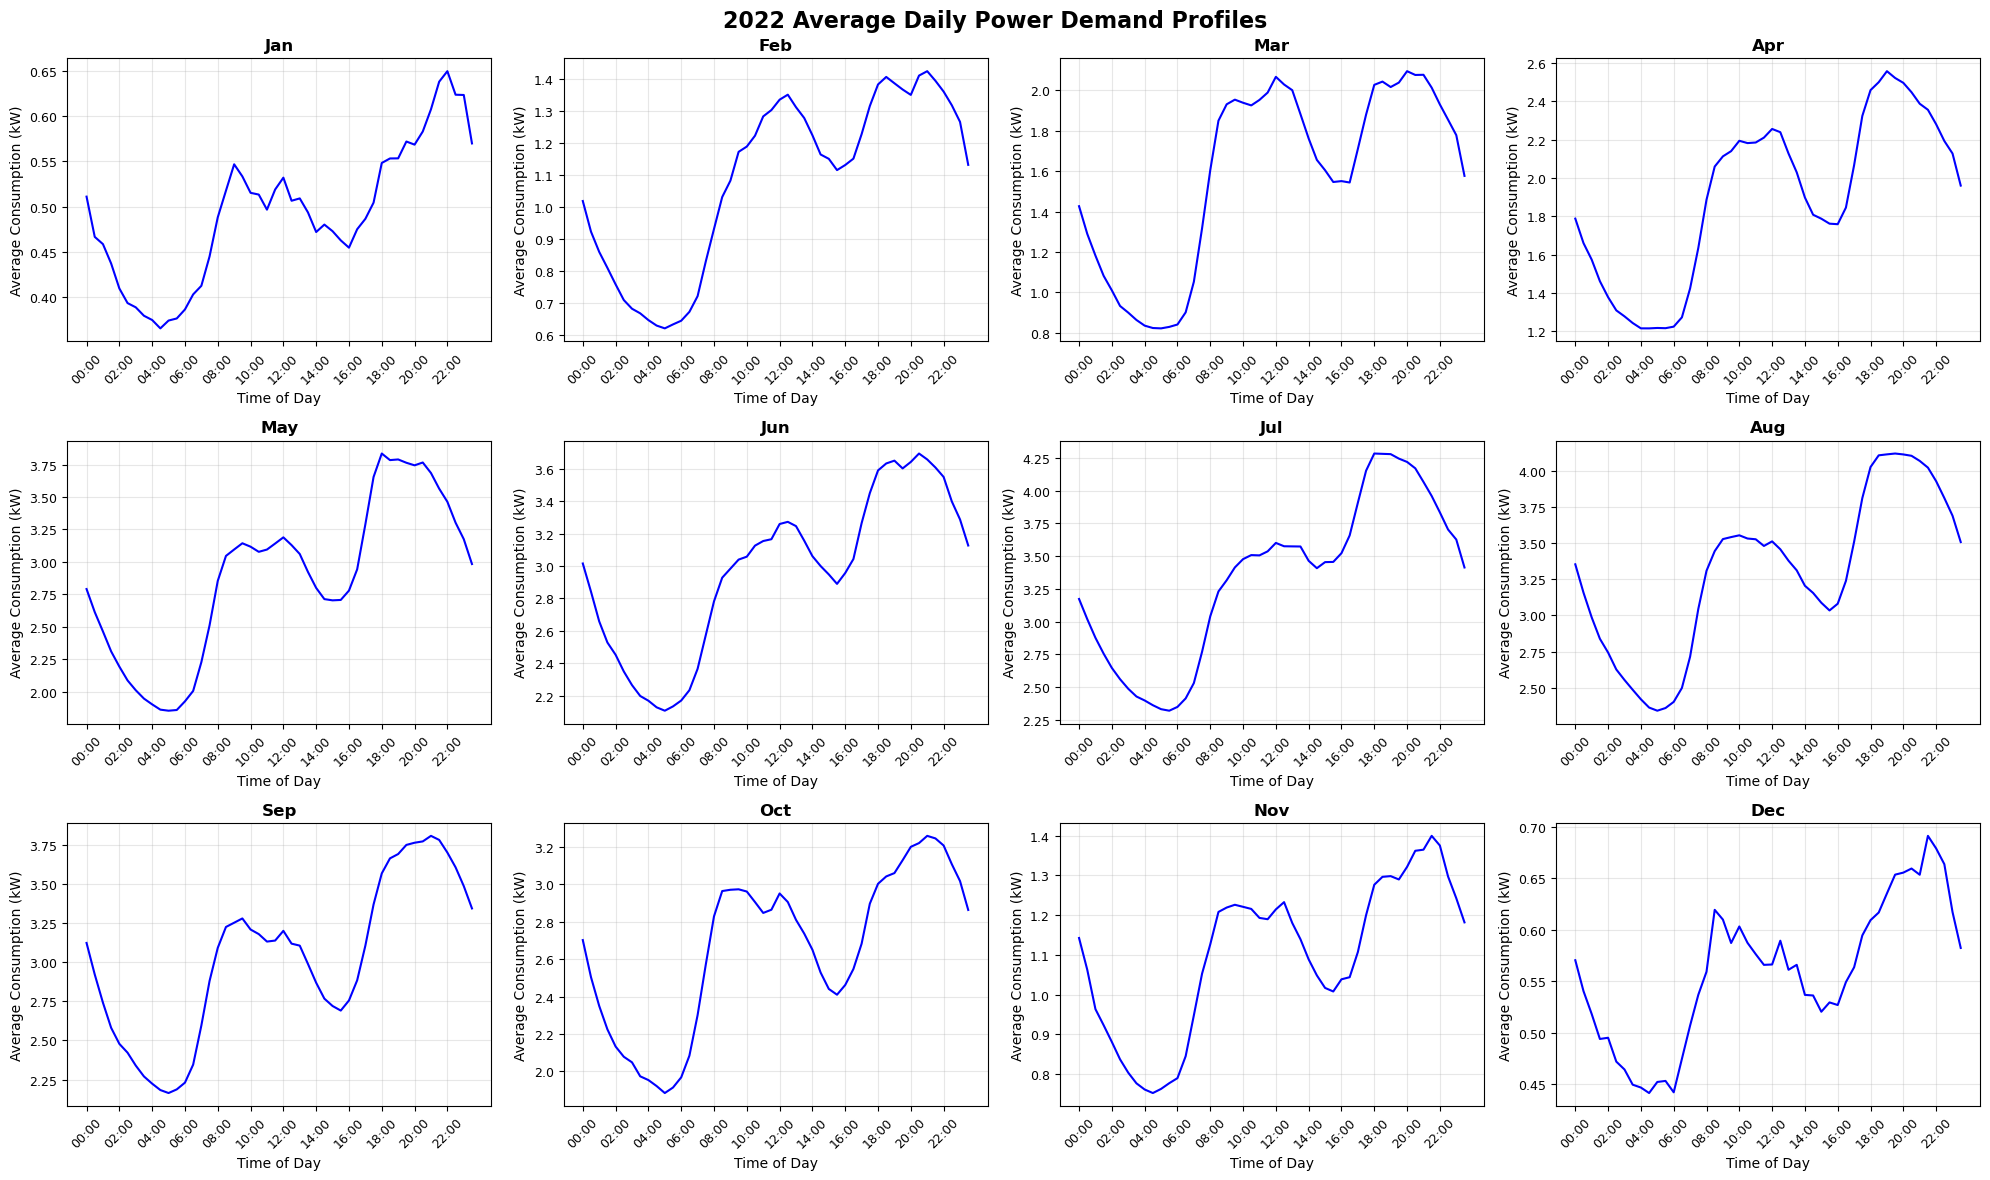

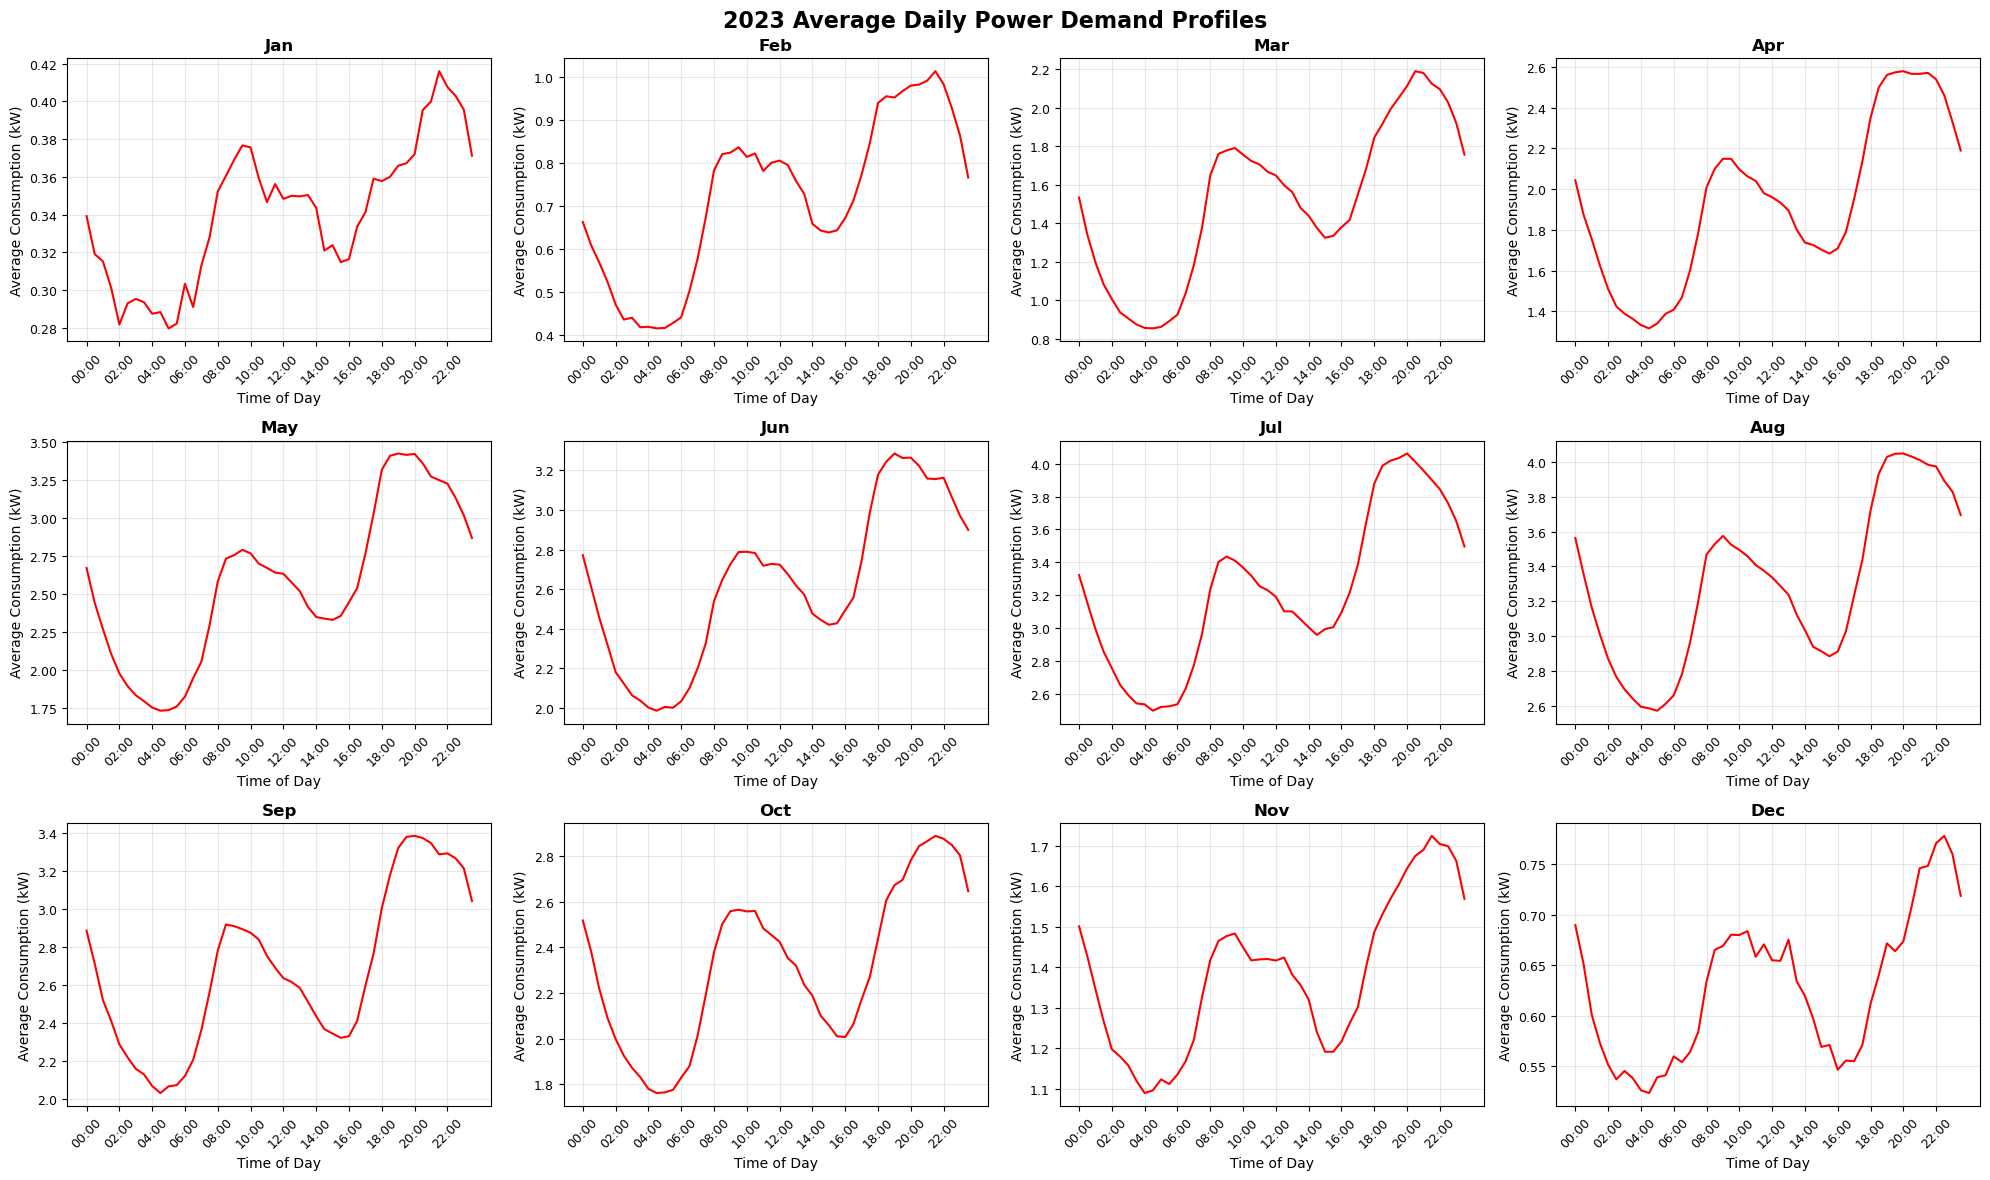

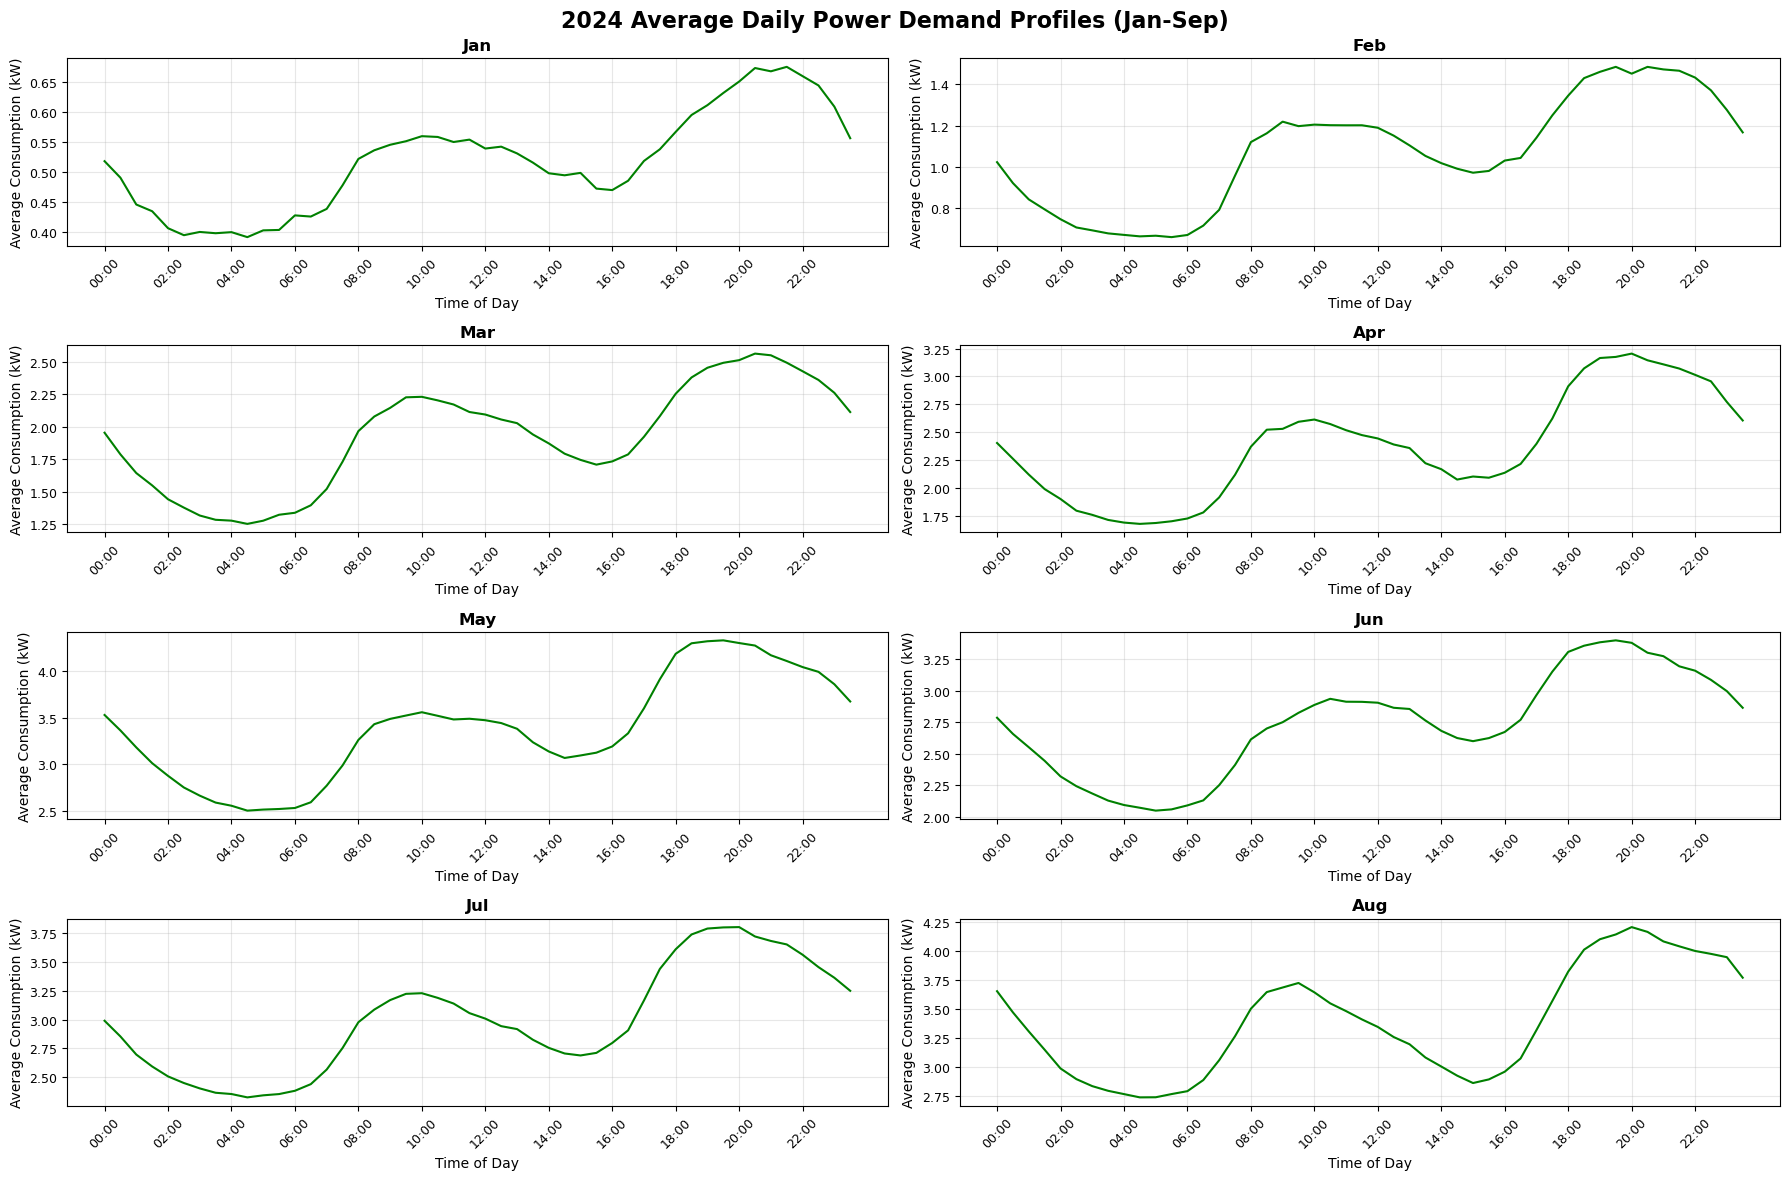

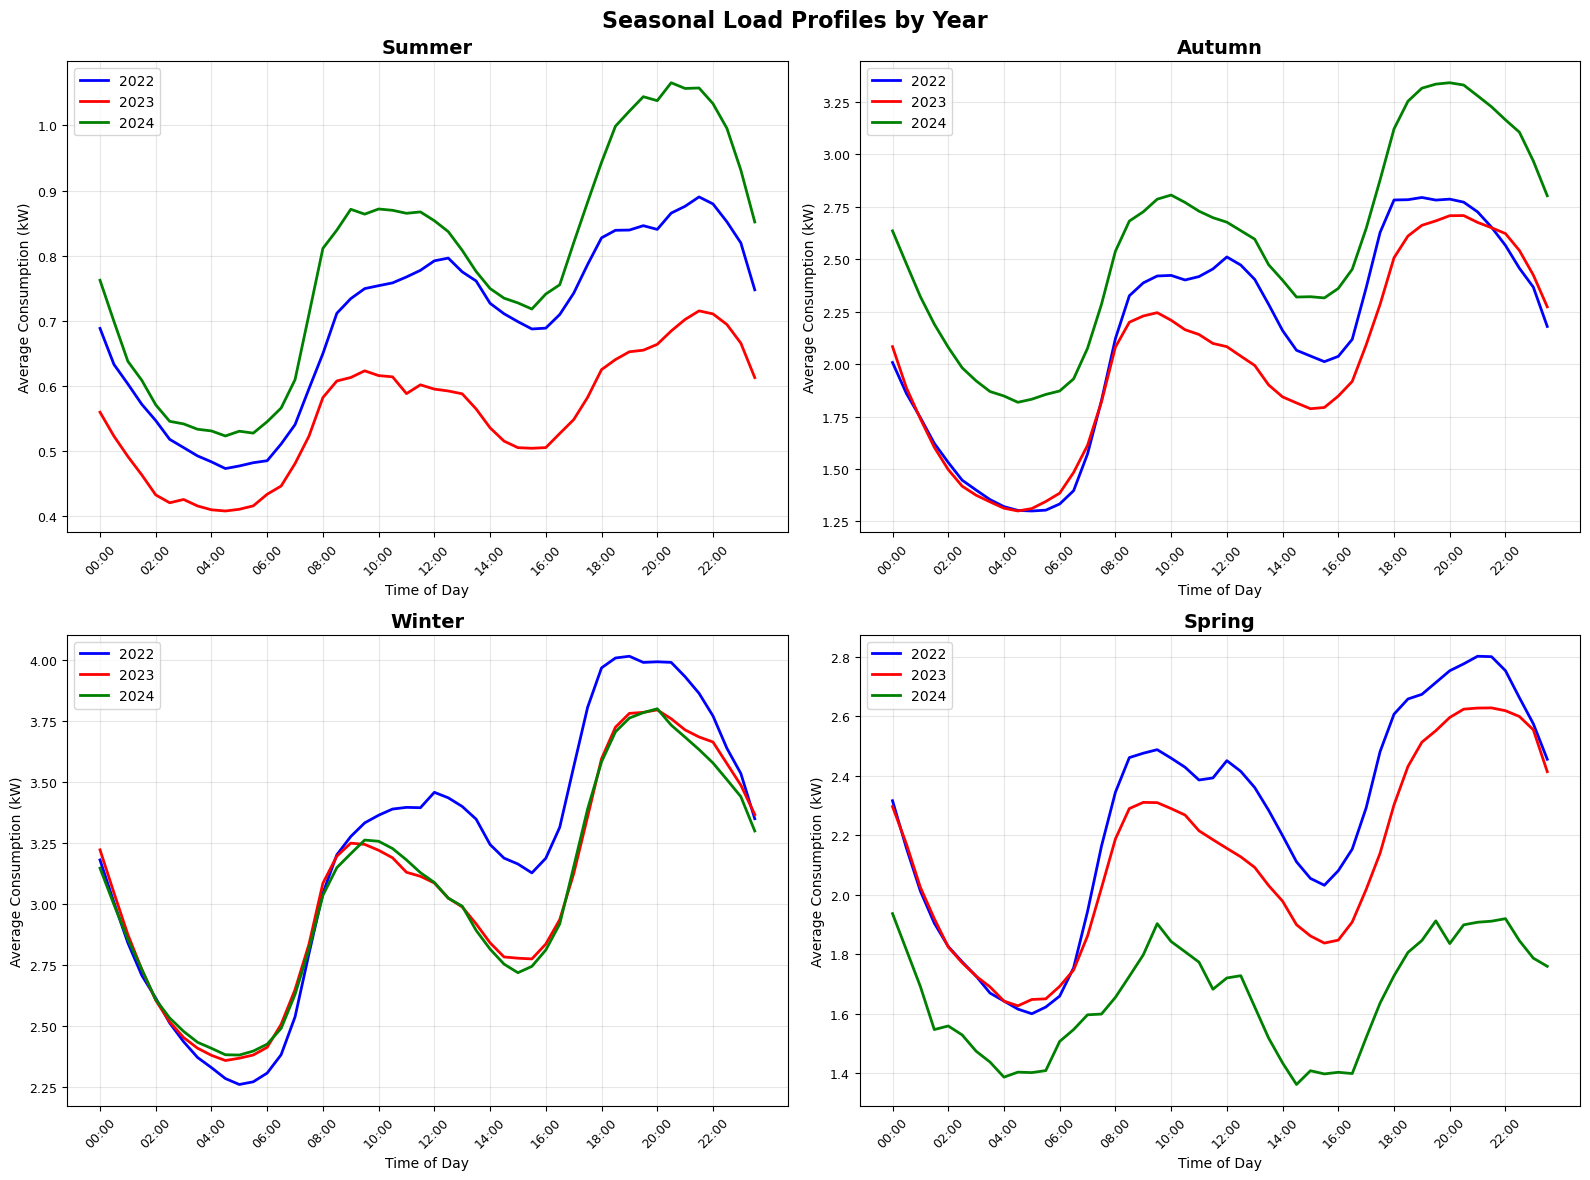

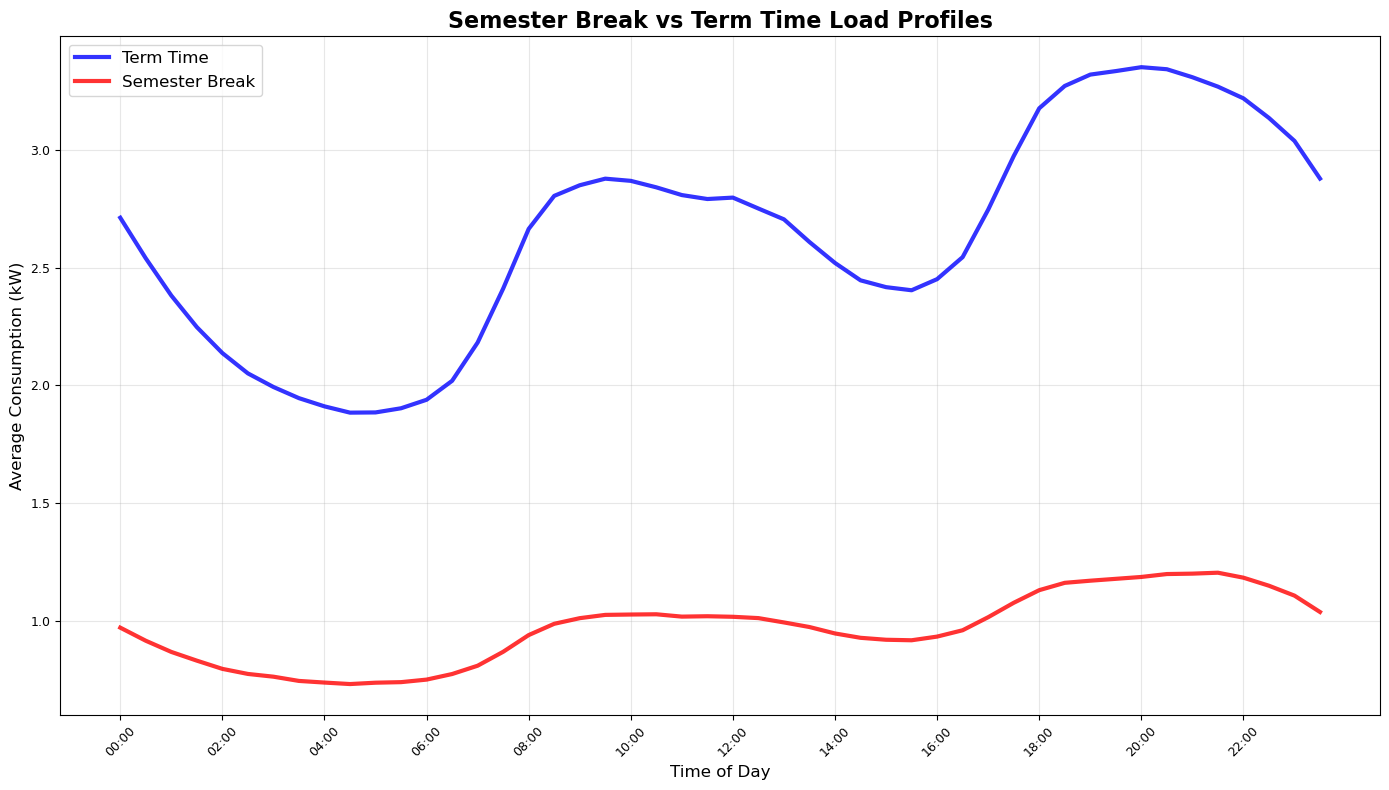


Period Summary:

Term Time (~616 days):
  Average consumption: 2.64 kW
  Peak: 3.35 kW at 20.00-20.30
  Minimum: 1.88 kW at 04.30-05.00
  Peak-to-minimum ratio: 1.78

Semester Break (~309 days):
  Average consumption: 0.97 kW
  Peak: 1.20 kW at 21.30-22.00
  Minimum: 0.73 kW at 04.30-05.00
  Peak-to-minimum ratio: 1.65

Data Distribution:
  Term Time: 72,690 records (66.6%)
  Semester Break: 36,499 records (33.4%)


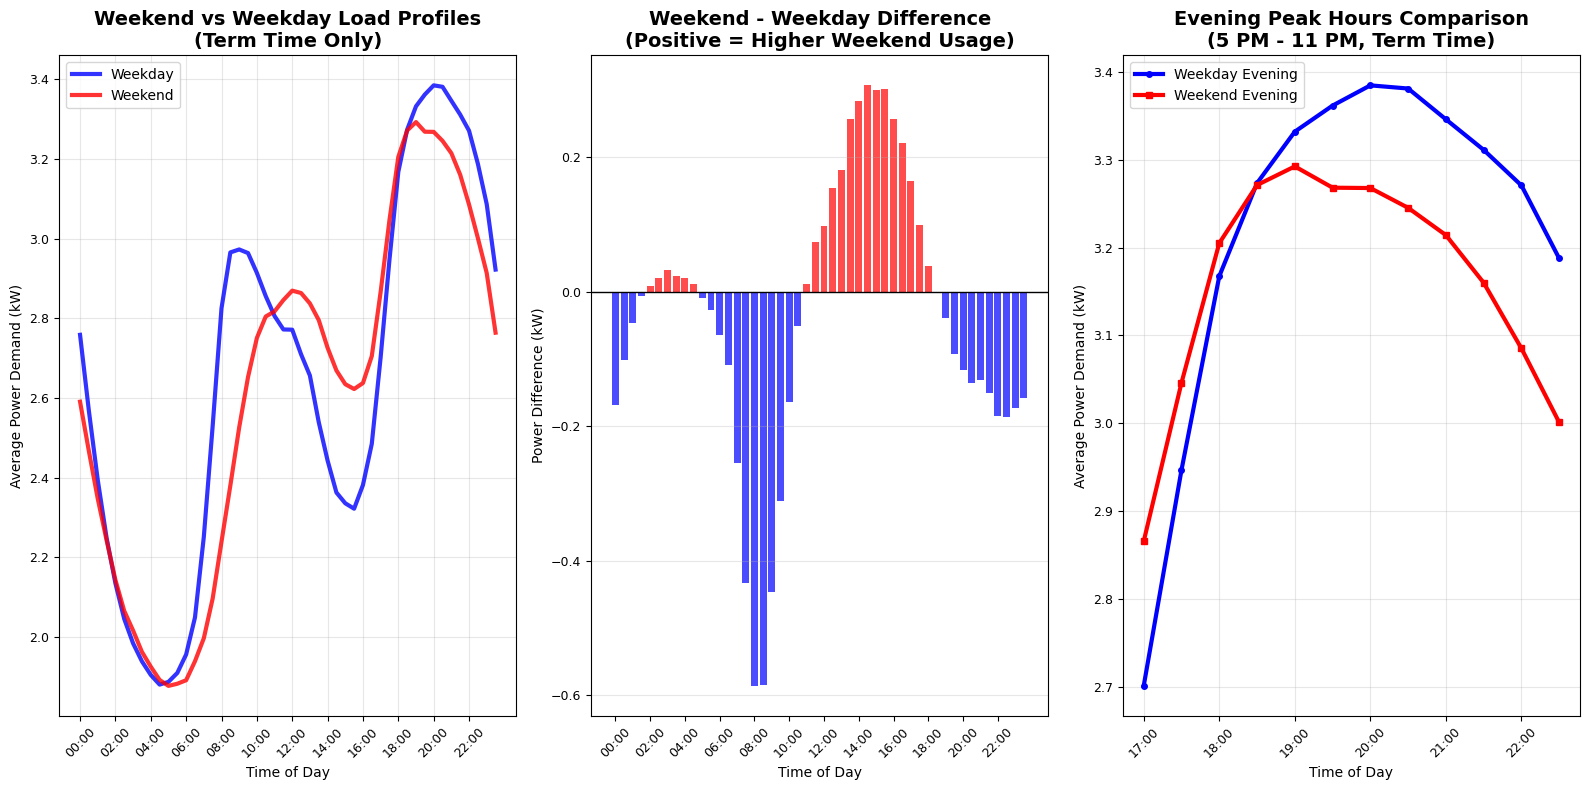


Day Type Summary (Term Time Only):

Weekday (~447 days):
  Average consumption: 2.65 kW
  Peak: 3.38 kW at 20.00-20.30
  Minimum: 1.88 kW at 04.30-05.00
  Peak-to-minimum ratio: 1.80

Weekend (~168 days):
  Average consumption: 2.61 kW
  Peak: 3.29 kW at 19.00-19.30
  Minimum: 1.88 kW at 05.00-05.30
  Peak-to-minimum ratio: 1.75

Term Time Data Distribution:
  Weekday: 52,826 records (72.7%)
  Weekend: 19,864 records (27.3%)
Exam Period Identification Results:
  Total records: 109,189
  Exam Period: 11,228 records (10.3%)
  Regular Term: 97,961 records (89.7%)


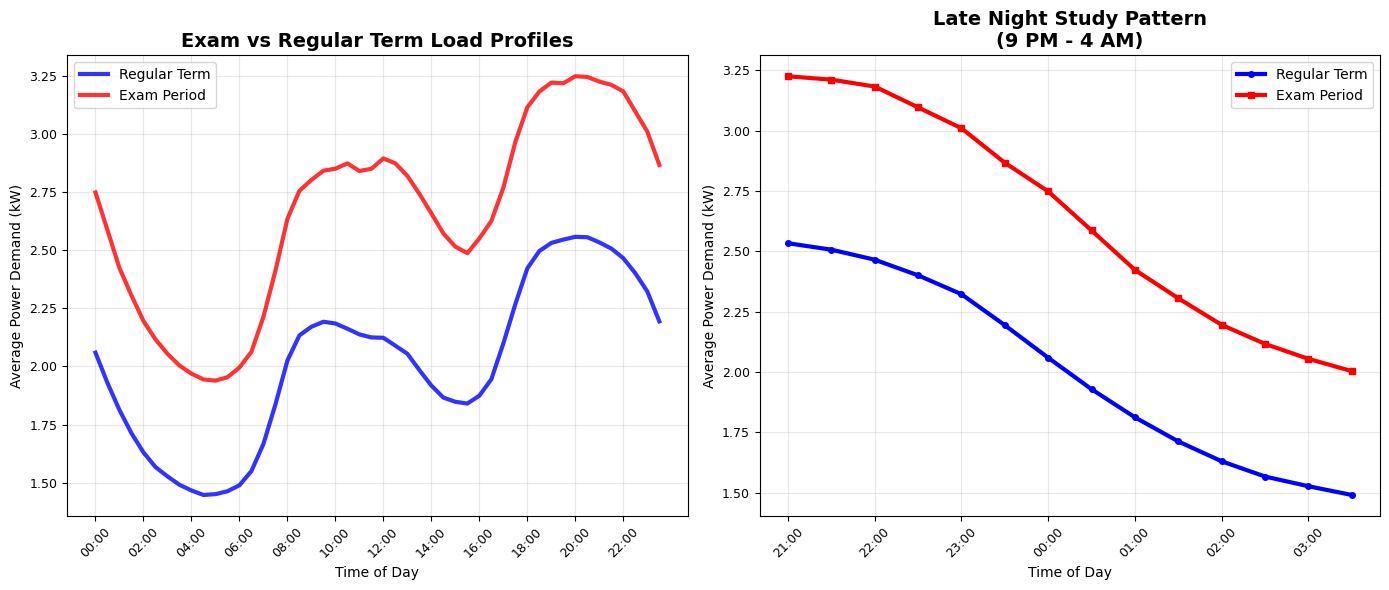


Period Summary:

Regular Term (~830 days):
  Average consumption: 2.01 kW
  Peak: 2.56 kW at 20.00-20.30
  Minimum: 1.45 kW at 04.30-05.00
  Peak-to-minimum ratio: 1.77

Exam Period (~95 days):
  Average consumption: 2.66 kW
  Peak: 3.25 kW at 20.00-20.30
  Minimum: 1.94 kW at 05.00-05.30
  Peak-to-minimum ratio: 1.67

Late Night Study Analysis (9 PM - 4 AM):
  Regular Term: 2.01 kW
  Exam Period: 2.64 kW
  Exam/Regular ratio: 1.32x
Exam Period Identification Results:
  Total records: 109,189
  Exam Period: 11,228 records (10.3%)
  Regular Term: 97,961 records (89.7%)


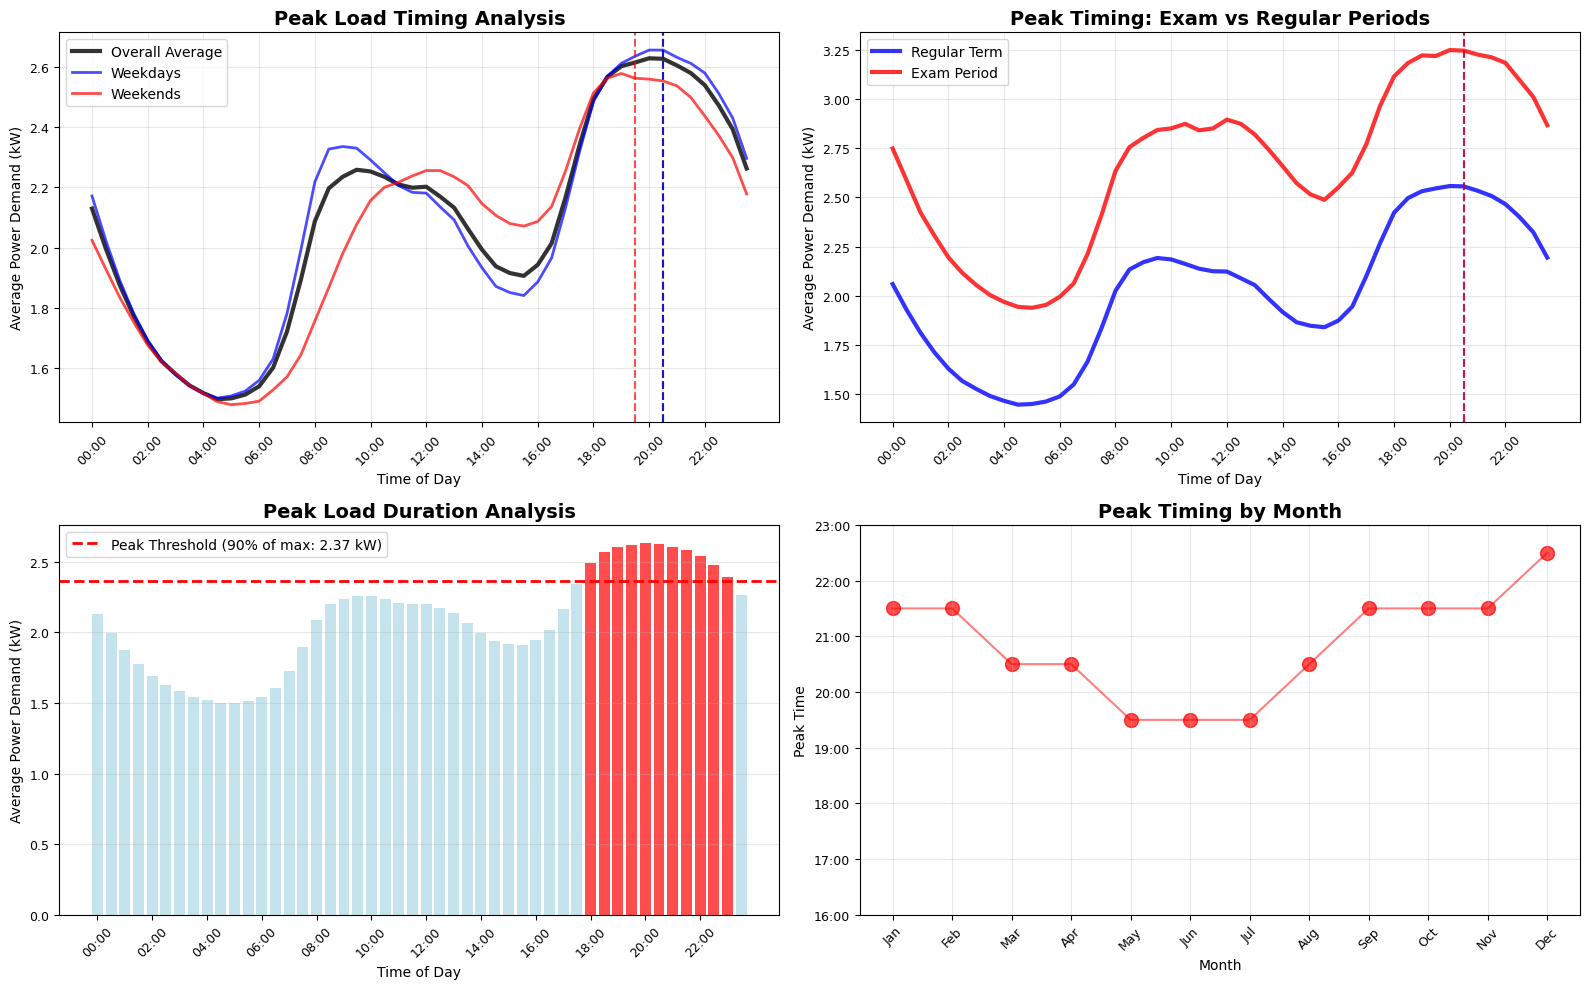

Peak load timing analysis summary

Overall Peak Analysis:
  Peak time: 20:30
  Peak value: 2.63 kW
  Peak duration (≥90% max): 11 intervals (5.5 hours)

Weekday vs Weekend Peak Timing:
  Weekday peak: 20:30 (2.66 kW)
  Weekend peak: 19:30 (2.58 kW)
  Time difference: 1.0 hours

Exam vs Regular Peak Timing:
  Regular term peak: 20:30 (2.56 kW)
  Exam period peak: 20:30 (3.25 kW)
  Exam peak increase: +27.0%

Seasonal Peak Variation:
  Earliest monthly peak: 19:30
  Latest monthly peak: 22:30
  Seasonal variation: 3.0 hours


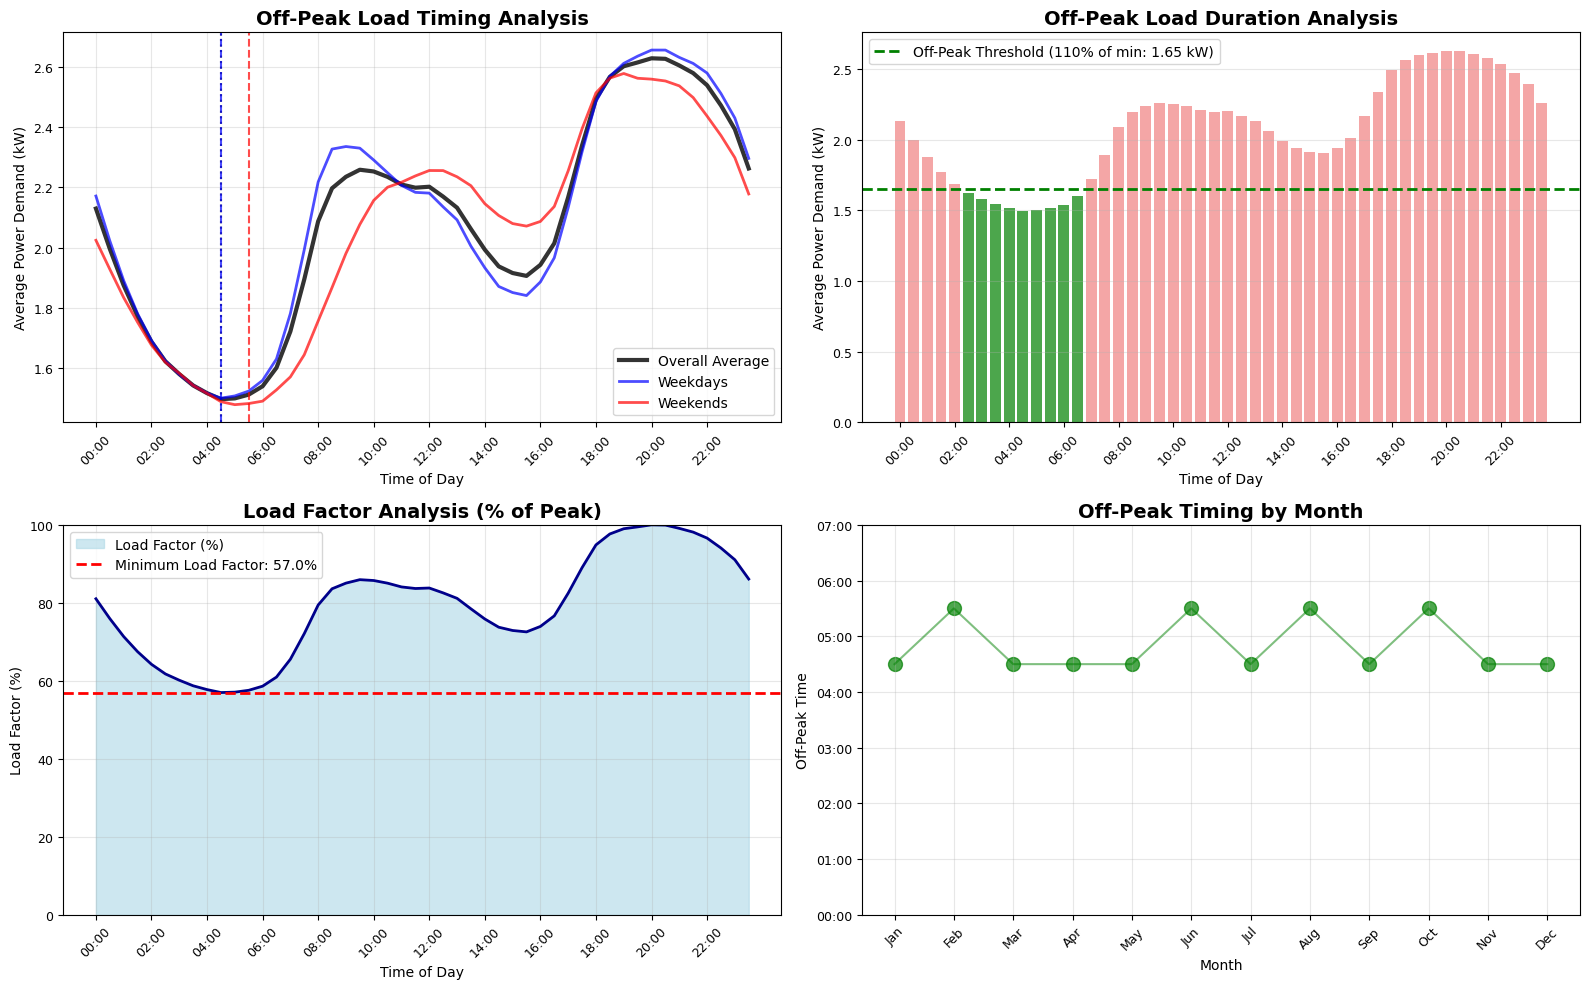

Off-peak load timing analysis summary

Overall Off-Peak Analysis:
  Off-peak time: 04:30
  Minimum load: 1.50 kW
  Maximum load: 2.63 kW
  Load variation: 75.4%
  Off-peak duration (≤110% min): 9 intervals (4.5 hours)

Weekday vs Weekend Off-Peak Timing:
  Weekday off-peak: 04:30 (1.50 kW)
  Weekend off-peak: 05:30 (1.48 kW)
  Time difference: 1.0 hours

Load Shifting Potential:
  Maximum spare capacity: 1.13 kW
  Load factor range: 57.0% - 100%
  Available capacity: 43.0% of peak demand

Seasonal Off-Peak Variation:
  Earliest monthly off-peak: 04:30
  Latest monthly off-peak: 05:30
  Seasonal variation: 1.0 hours


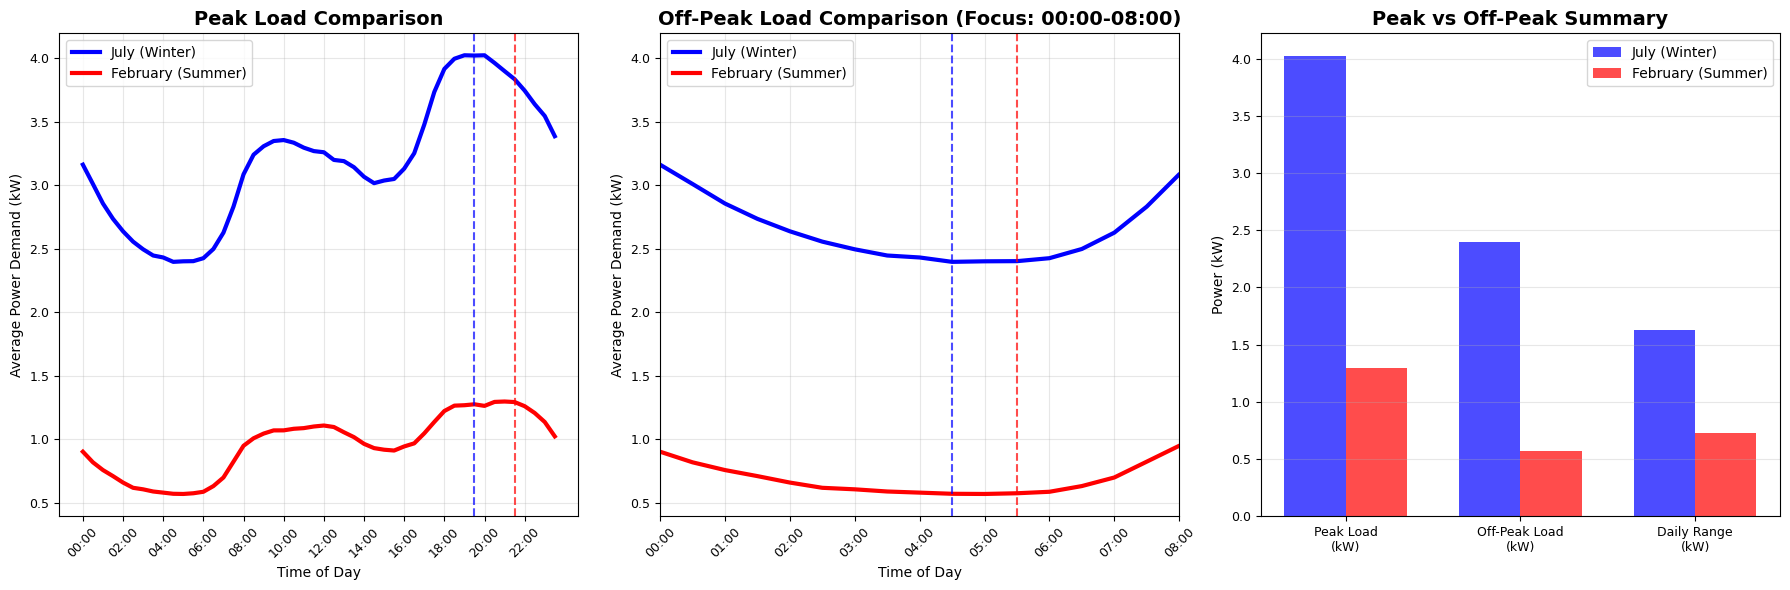


JULY (PEAK WINTER) ANALYSIS:
Peak time: 19:30 | Peak value: 4.02 kW
Off-peak time: 04:30 | Off-peak value: 2.40 kW
Daily range: 1.63 kW
Average consumption: 3.18 kW
Data points: 10,459 records

FEBRUARY (PEAK SUMMER) ANALYSIS:
Peak time: 21:30 | Peak value: 1.30 kW
Off-peak time: 05:30 | Off-peak value: 0.57 kW
Daily range: 0.73 kW
Average consumption: 0.96 kW
Data points: 9,574 records

PEAK LOAD COMPARISON:
Peak difference: +2.73 kW (+210.5%)
Peak timing difference: -2.0 hours (July vs February)

 OFF-PEAK LOAD COMPARISON:
Off-peak difference: +1.83 kW (+322.2%)
Off-peak timing difference: -1.0 hours (July vs February)

 LOAD SHIFTING OPPORTUNITIES:
Winter load shifting potential: 1.63 kW
Summer load shifting potential: 0.73 kW
Better season for load management: Winter


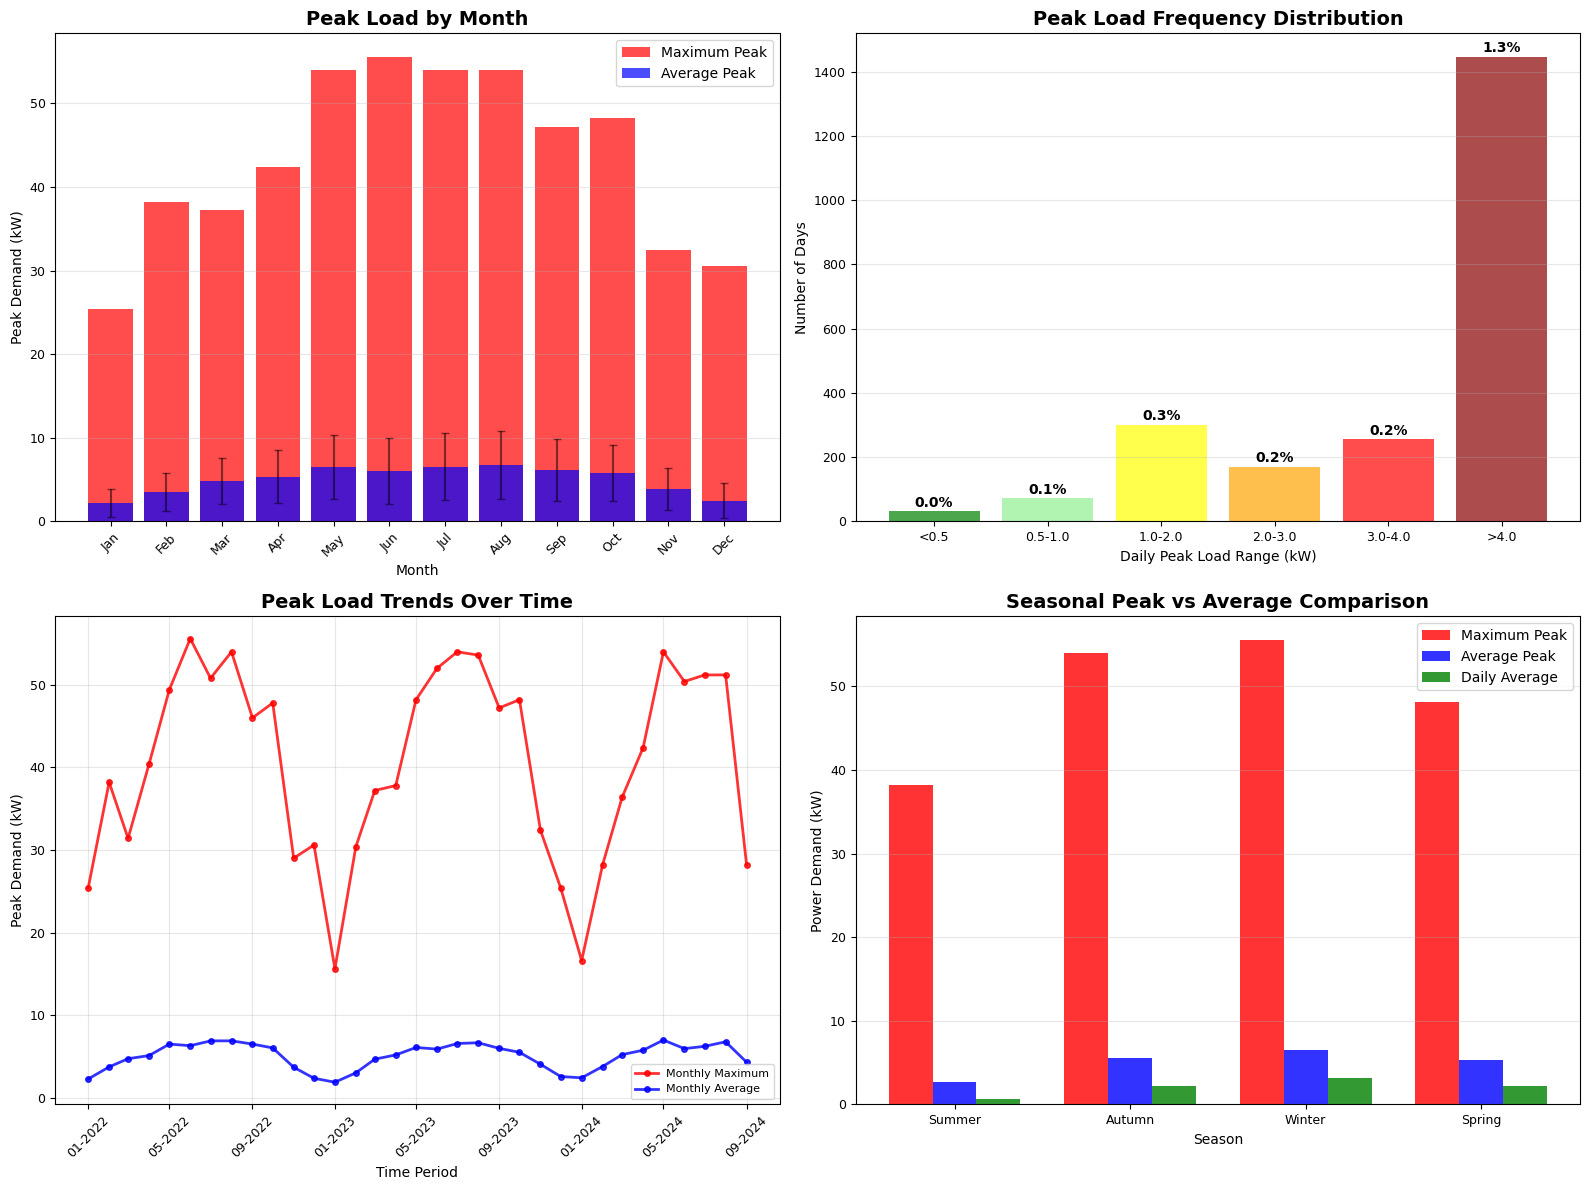

Peak Demand Analysis Summary

Overall Peak Statistics:
  Absolute maximum peak: 55.60 kW
  Average daily peak: 5.05 kW
  Standard deviation: 3.59 kW
  95th percentile: 9.18 kW
  90th percentile: 8.14 kW

Peak Frequency Analysis:
  High peaks (≥4.0 kW): 69438 days (63.6%)
  Medium peaks (2.0-4.0 kW): 20387 days (18.7%)
  Low peaks (<2.0 kW): 19364 days (17.7%)

Seasonal Peak Analysis:
  Summer:
    Maximum peak: 38.20 kW
    Average peak: 2.71 kW
    Peak-to-average ratio: 6.82
  Autumn:
    Maximum peak: 54.00 kW
    Average peak: 5.58 kW
    Peak-to-average ratio: 3.18
  Winter:
    Maximum peak: 55.60 kW
    Average peak: 6.45 kW
    Peak-to-average ratio: 2.75
  Spring:
    Maximum peak: 48.20 kW
    Average peak: 5.26 kW
    Peak-to-average ratio: 3.50

Top 5 Peak Demand Days:
  2022-06-11: 55.60 kW (Winter)
  2022-08-08: 54.00 kW (Winter)
  2023-07-27: 54.00 kW (Winter)
  2024-05-28: 54.00 kW (Autumn)
  2023-08-11: 53.60 kW (Winter)


In [62]:
df = run_all_load_profile_plots()